## SAFE






**Feature selection** methods are intended to reduce the number of input variables to those that are believed to be most useful to a model in order to predict the target variable.

Feature selection is primarily focused on removing non-informative or redundant predictors from the model.

In [ ]:
%logstop
%logstart -ort afs.py append

Activating auto-logging. Current session state plus future input saved.
Filename       : afs.py
Mode           : append
Output logging : True
Raw input log  : True
Timestamping   : True
State          : active


In [ ]:
!pip install ppscore

In [ ]:
!pip install skope-rules

In [ ]:
# !pip install pdpbox

!pip install git+git://github.com/SauceCat/PDPbox.git

  Cloning git://github.com/SauceCat/PDPbox.git to /tmp/pip-req-build-0txh9ww2
  Running command git clone -q git://github.com/SauceCat/PDPbox.git /tmp/pip-req-build-0txh9ww2
  Created wheel for PDPbox: filename=PDPbox-0.2.0+13.g73c6966-cp37-none-any.whl size=57691683 sha256=89b1eccc6e30751ad5e614bbc6e6758dce72bf249ee3efc9dba68a3fe6735416
  Stored in directory: /tmp/pip-ephem-wheel-cache-gkqsjtmg/wheels/11/eb/be/17660ed57adfa7acc42644dca8609955089c4a92d621eb9c40
Successfully built PDPbox


In [ ]:
!pip install git+git://github.com/christophM/rulefit.git

  Cloning git://github.com/christophM/rulefit.git to /tmp/pip-req-build-nrslmi0j
  Running command git clone -q git://github.com/christophM/rulefit.git /tmp/pip-req-build-nrslmi0j
  Created wheel for RuleFit: filename=RuleFit-0.3-cp37-none-any.whl size=8773 sha256=6a89ab9b360cc90392db14df81467a8ff18ca2f24c358937c246716e16ac632b
  Stored in directory: /tmp/pip-ephem-wheel-cache-lp6hf77v/wheels/0b/51/b8/9dc135361d610b383e5029f82ceb5b73eef717e0c1212c8cd1
Successfully built RuleFit


In [ ]:
import os
import math
import time
import random
random.seed(42)

import numpy as np 
import pandas as pd
import seaborn as sns
import ppscore as pps

import itertools
import functools
from itertools import combinations
from functools import reduce
# Scikit learn 
import sklearn
from sklearn import tree
from sklearn import svm
from sklearn.base import clone
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

# Stats
from scipy import stats

# GBDT
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier




from distutils.version import LooseVersion
if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
    # In sklearn version 0.24, forest module changed to be private.
    from sklearn.ensemble._forest import _generate_unsampled_indices
    from sklearn.ensemble import _forest as forest
else:
    # Before sklearn version 0.24, forest was public, supporting this.
    from sklearn.ensemble.forest import _generate_unsampled_indices
    from sklearn.ensemble import forest

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.style.use('ggplot')

# Import skope-rules
from skrules import SkopeRules
# Import Rulefit
from rulefit import RuleFit



# Partial Dependecy packages
from pdpbox.pdp_calc_utils import _calc_ice_lines_inter
from pdpbox.pdp import pdp_isolate, PDPInteract
from pdpbox.utils import (_check_model, _check_dataset, _check_percentile_range, _check_feature,
                    _check_grid_type, _check_memory_limit, _make_list,
                    _calc_memory_usage, _get_grids, _get_grid_combos, _check_classes)
from joblib import Parallel, delayed




from IPython.display import Latex
from pandas.api.types import is_numeric_dtype


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth',None)


rs = {'random_state': 42}

In [ ]:
# # show versions of packages
# import sys

# def get_imports():
#     for name, val in globals().items():
#         if isinstance(val, types.ModuleType):
#             # Split ensures you get root package, 
#             # not just imported function
#             name = val.__name__.split(".")[0]
#         elif isinstance(val, type):
#             name = val.__module__.split(".")[0]
#         # Some packages are weird and have different
#         # imported names vs. system/pip names. Unfortunately,
#         # there is no systematic way to get pip names from
#         # a package's imported name. You'll have to add
#         # exceptions to this list manually!
#         poorly_named_packages = {
#             "sklearn": "scikit-learn"
#         }
#         if name in poorly_named_packages.keys():
#             name = poorly_named_packages[name]
#         yield name.lower()
# imports = list(set(get_imports()))

# # The only way I found to get the version of the root package
# # from only the name of the package is to cross-check the names 
# # of installed packages vs. imported packages
# modules = []
# for m in sys.builtin_module_names:
#     if m.lower() in imports and m !='builtins':
#         modules.append((m,'Python BuiltIn'))
#         imports.remove(m.lower())

# for m in pkg_resources.working_set:
#     if m.project_name.lower() in imports and m.project_name!="pip":
#         modules.append((m.project_name, m.version))
#         imports.remove(m.project_name.lower())

# for m in sys.modules:
#     if m.lower() in imports and m !='builtins':
#         modules.append((m,'unknown'))

# # print('System=='+platform.system()+' '+platform.release()+'; Version=='+platform.version())
# for r in modules:
#     print("{}=={}".format(*r))

In [ ]:

from IPython.display import display_html
def display_side_by_side(*args):
    """
    Displays dataframe Side-by-Side

    Params
    ===============================
    df


    """
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def display_side_by_side_cap(dfs:list, captions:list):
    """
    Display tables side by side to save vertical space

    Params
    ===========================================
        dfs        : list of pandas.DataFrame
        captions   : list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# display_side_by_side([chi_df, p_df, sam], ['Chi-Square', 'p-value', 'PBS_Corr'])

In [ ]:
class bcolors:
    """
    Prints colored Text
    """

    ResetAll = "\033[0m"

    Bold       = "\033[1m"
    Dim        = "\033[2m"
    Underlined = "\033[4m"
    Blink      = "\033[5m"
    Reverse    = "\033[7m"
    Hidden     = "\033[8m"

    ResetBold       = "\033[21m"
    ResetDim        = "\033[22m"
    ResetUnderlined = "\033[24m"
    ResetBlink      = "\033[25m"
    ResetReverse    = "\033[27m"
    ResetHidden     = "\033[28m"

    Default      = "\033[39m"
    Black        = "\033[30m"
    Red          = "\033[31m"
    Green        = "\033[32m"
    Yellow       = "\033[33m"
    Blue         = "\033[34m"
    Magenta      = "\033[35m"
    Cyan         = "\033[36m"
    LightGray    = "\033[37m"
    DarkGray     = "\033[90m"
    LightRed     = "\033[91m"
    LightGreen   = "\033[92m"
    LightYellow  = "\033[93m"
    LightBlue    = "\033[94m"
    LightMagenta = "\033[95m"
    LightCyan    = "\033[96m"
    White        = "\033[97m"

    BackgroundDefault      = "\033[49m"
    BackgroundBlack        = "\033[40m"
    BackgroundRed          = "\033[41m"
    BackgroundGreen        = "\033[42m"
    BackgroundYellow       = "\033[43m"
    BackgroundBlue         = "\033[44m"
    BackgroundMagenta      = "\033[45m"
    BackgroundCyan         = "\033[46m"
    BackgroundLightGray    = "\033[47m"
    BackgroundDarkGray     = "\033[100m"
    BackgroundLightRed     = "\033[101m"
    BackgroundLightGreen   = "\033[102m"
    BackgroundLightYellow  = "\033[103m"
    BackgroundLightBlue    = "\033[104m"
    BackgroundLightMagenta = "\033[105m"
    BackgroundLightCyan    = "\033[106m"
    BackgroundWhite        = "\033[107m"


# print(f"{bcolors.LightBlue}Warning: No active frommets remain. Continue?{bcolors.ResetAll}")

In [ ]:
# Classification - Model Pipeline
def train_models(X_train, X_val, X_test, y_train, y_val, y_test):
    log_reg = LogisticRegression(**rs)
    nb = BernoulliNB()
    knn = KNeighborsClassifier()
    svm = SVC(**rs)
    mlp = MLPClassifier(max_iter=5000, **rs)
    dt = DecisionTreeClassifier(**rs)
    et = ExtraTreesClassifier(**rs)
    rf = RandomForestClassifier(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    scorer = make_scorer(f1_score)

    clfs = [('Logistic Regression', log_reg), ('Naive Bayes', nb),
            ('K-Nearest Neighbors', knn), ('SVM', svm), 
            ('MLP', mlp), ('Decision Tree', dt), ('Extra Trees', et), 
            ('Random Forest', rf), ('XGBoost', xgb)]
    pipelines = []
    scores_df = pd.DataFrame(columns=['Model', 'Val_Score', 'F1_Score'])
    test_scores = []
    for clf_name, clf in clfs:
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('classifier', clf)])
        pipeline.fit(X_train, y_train)
        val_score = cross_val_score(pipeline, X_val, y_val, scoring=scorer, cv=3).mean()
        print(f'{clf_name}\n{"-" * 30}\nModel Val-Score: {val_score:.4f}')
        test_score = f1_score(y_test, pipeline.predict(X_test))
        print(f'Model F1-Score: {test_score:.4f}\n\n')
        pipelines.append(pipeline)
        scores_df = scores_df.append({'Model': clf_name, 
                                      'Val_Score': val_score, 
                                      'F1_Score': test_score}, ignore_index=True)
    return pipelines, scores_df

In [ ]:


def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print("Finished {} in {} secs".format(repr(func.__name__), round(run_time, 3)))
        return value

    return wrapper

# https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/

In [ ]:
def variance(df, var_threshold):

    """
    Drops Low variance columns on the given Threshold

    Params
    ====================================
    df              : Dataframe
    var_threshold   : Variance Threshold(float)

    Returns
    ====================================
    df              : Dataframe dropping low variance columns
    constant_columns: list of columns dropped
    """

    # throws away all features with variance below var_threshold * (1-var_threshold)
    constant_filter = VarianceThreshold(var_threshold * (1-var_threshold))
    constant_filter.fit(df)
    constant_columns = [column for column in df.columns
                        if column not in df.columns[constant_filter.get_support()]]

    df_var = df.drop(columns = list(constant_columns))

    print(f'Columns dropped on Low Variance : {constant_columns}')

    return df_var, constant_columns


def correlation(df, corr_threshold):
    """
    Drops High Correlation columns on the given Threshold

    Params
    ====================================
    df              : Dataframe
    corr_threshold  : Correlation Threshold(float)

    Returns
    ====================================
    df              : Dataframe dropping High Correlation columns
    col_corr        : list of columns dropped
    """
    
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = df.corr()

    del_cols = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= corr_threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)

    
    df_mcr = df.drop(columns = list(col_corr)) # deleting the column from the dataset
    print(f'Columns dropped on Correlation Threshold : {list(col_corr)}')               

    return df_mcr, list(col_corr)

@timer
def minimalPreprocessing(df, 
                         target, 
                         corr_threshold=0.95, 
                         var_threshold=0.95, 
                         drop_tresh = 0.3, 
                        #  cardinality_thresh=30, 
                         drop_cat=False):
    
    """
    Preprocessing

    Params
    ====================================
    df              : Dataframe
    target          : target column name(str)
    corr_threshold  : Correlation Threshold(float)
    var_threshold   : Variance Threshold(float)
    drop_tresh      : Threshold to drop columns having null values(float)
    drop_cat        : Drop Categorical columns(Bool)

    Return
    ==========================================
    df_v            : Cleaned Dataframe
    object_cols_f   : list of object columns
    numeric_cols_f  : list of numeric columns
    """
    
    # Add Encoders for cat

    print(f"{bcolors.LightBlue}=={bcolors.ResetAll}"*40)
    print(f"{bcolors.Magenta}Data Preproccesing Initiated{bcolors.ResetAll}")
    print(f"{bcolors.LightBlue}=={bcolors.ResetAll}"*40)
    print(f"{bcolors.Magenta}Shape of the Dataframe : {df.shape}{bcolors.ResetAll}")

    # remove columns having null values more than 30%
    drop_pct = df.shape[0]*drop_tresh
    df1 = df.dropna(thresh=drop_pct ,how='all', axis=1)
    
    print(f"{bcolors.Blue}Shape of the Dataframe dropping Cols having NaN > 30%: {df1.shape}{bcolors.ResetAll}")
    
    df = df1.copy()

    # Rename columns with "space" to "_"
    df.columns = [i.replace(' ','_') for i in df.columns]
    
    # Separate object & numeric cols
    object_cols = list(df.select_dtypes(exclude=np.number).columns)
    numeric_cols = list(df.select_dtypes(include=np.number).columns)

    # Fill missing values with arbitary number
    d1 = dict.fromkeys(df.select_dtypes(np.number).columns, -999)
    d2 = dict.fromkeys(df.columns.difference(d1.keys()), 'Missing')
    # Merge both dicts
    d = {**d1, **d2}

    df = df.fillna(d)

    # Cardinality check
    # cardinal = [col for col in object_cols if df[col].nunique() <= cardinality_thresh]
    # high_cardinality_cols = list(set(object_cols)-set(cardinal))
    # print(f'{bcolors.Red}High Cardinality colums > 30 : {high_cardinality_cols}{bcolors.ResetAll}')
    

    # Encoding Cat
    if drop_cat:
        data = df.drop(columns = object_cols)

    elif len(object_cols) >= 1:

        df[object_cols].astype(object)

        # One-Hot Encoder
        # data = pd.get_dummies(df, columns = cardinal)

        # Ordinal Encoder
        enc = OrdinalEncoder()
        df[object_cols] = enc.fit_transform(df[object_cols])

        # df.drop(columns=high_cardinality_cols, inplace=True)
        print(f"{bcolors.Cyan}Columns Encoding : {object_cols}{bcolors.ResetAll}")
        print(f"{bcolors.Cyan}Shape of the Dataframe Encoding Cat : {df.shape}{bcolors.ResetAll}")
        data = df.copy()
        
    else:
        print(f"{bcolors.Cyan}No Object Columns{bcolors.ResetAll}")
        data = df.copy()

    
    # Feature Eliminations
    # Remove highly correlation features
    df_c, corr_feats = correlation(data, corr_threshold)

    # Remove high variance features
    df_v, const_feats = variance(df_c, var_threshold)

    print(f"{bcolors.Yellow}Shape of the Dataframe dropping Corr & Var Threshold : {df_v.shape}{bcolors.ResetAll}")
    print(f"{bcolors.LightBlue}=={bcolors.ResetAll}"*40)

    removed_feats = corr_feats + const_feats


    object_cols_f = list(set(object_cols)-set(removed_feats))
    numeric_cols_f = list(set(numeric_cols)-set(removed_feats))

    # Remove target col
    numeric_cols_f = [x for x in numeric_cols_f if x != target]

    print(object_cols_f)
    print(numeric_cols_f)

    # Value Count & Percentage for object columns
    c = df[object_cols_f].apply(lambda x: x.value_counts(dropna=False)).T.stack().astype(int)
    p = (df[object_cols_f].apply(lambda x: x.value_counts(normalize=True, 
                                                          dropna=False)).T.stack() * 100).round(2)

    cp = pd.concat([c,p], axis=1, keys=['Count', 'Percentage %'])

    display(cp)

    return df_v, object_cols_f, numeric_cols_f

In [ ]:
leads = pd.read_csv("Leads.csv")
leads.drop(columns=["Prospect ID", "Lead Number"], inplace=True)

In [ ]:
leads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [ ]:
# Test
########################################################################

leads_c, object_cols, numeric_cols = minimalPreprocessing(leads, 
                                                          "Converted", 
                                                            0.95, 
                                                            0.98, 
                                                            drop_tresh = 0.3, 
                                                            drop_cat=False)

Data Preproccesing Initiated
Shape of the Dataframe : (9240, 35)
Shape of the Dataframe dropping Cols having NaN > 30%: (9240, 35)
Columns Encoding : ['Lead_Origin', 'Lead_Source', 'Do_Not_Email', 'Do_Not_Call', 'Last_Activity', 'Country', 'Specialization', 'How_did_you_hear_about_X_Education', 'What_is_your_current_occupation', 'What_matters_most_to_you_in_choosing_a_course', 'Search', 'Magazine', 'Newspaper_Article', 'X_Education_Forums', 'Newspaper', 'Digital_Advertisement', 'Through_Recommendations', 'Receive_More_Updates_About_Our_Courses', 'Tags', 'Lead_Quality', 'Update_me_on_Supply_Chain_Content', 'Get_updates_on_DM_Content', 'Lead_Profile', 'City', 'Asymmetrique_Activity_Index', 'Asymmetrique_Profile_Index', 'I_agree_to_pay_the_amount_through_cheque', 'A_free_copy_of_Mastering_The_Interview', 'Last_Notable_Activity']
Shape of the Dataframe Encoding Cat : (9240, 35)
Columns dropped on Correlation Threshold : ['Asymmetrique_Profile_Score', 'Page_Views_Per_Visit']
Columns dropped

Count  Percentage %
Lead_Quality                                  0.0     637          6.89
                                              1.0     583          6.31
                                              2.0    1560         16.88
                                              3.0    4767         51.59
                                              4.0    1092         11.82
                                              5.0     601          6.50
Specialization                                0.0     338          3.66
                                              1.0     403          4.36
                                              2.0      57          0.62
                                              3.0     112          1.21
                                              4.0     976         10.56
                                              5.0     159          1.72
                                              6.0     114          1.23
                                              7.0     848          9.18
                                              8.0     366          3.96
                                              9.0     178          1.93
                                              10.0    838          9.07
                                              11.0    203          2.20
                                              12.0   1438         15.56
                                              13.0    503          5.44
                                              14.0    100          1.08
                                              15.0     73          0.79
                                              16.0   1942         21.02
                                              17.0     40          0.43
                                              18.0    349          3.78
                                              19.0    203          2.20
Tags                                          0.0     465          5.03
                                              1.0     186          2.01
                                              2.0     358          3.87
                                              3.0      63          0.68
                                              4.0     111          1.20
                                              5.0       5          0.05
                                              6.0     117          1.27
                                              7.0       5          0.05
                                              8.0     513          5.55
                                              9.0       3          0.03
                                              10.0    175          1.89
                                              11.0      7          0.08
                                              12.0   3353         36.29
                                              13.0    145          1.57
                                              14.0      1          0.01
                                              15.0   1203         13.02
                                              16.0      2          0.02
                                              17.0      6          0.06
                                              18.0      2          0.02
                                              19.0      6          0.06
                                              20.0   2072         22.42
                                              21.0     12          0.13
                                              22.0     83          0.90
                                              23.0     27          0.29
                                              24.0     33          0.36
                                              25.0    240          2.60
                                              26.0     47          0.51
What_is_your_current_occupation               0.0       8          0.09
                                              1.0      10          0.11
                    

Finished 'minimalPreprocessing' in 0.449 secs


In [ ]:

# Variance Inflation Factor (VIF)
def calculateVIF(exogs, data):
    """
    Calculates Variance inflation factor (VIF) is a technique to estimate the 
    severity of multicollinearity among independent variables within the context
    of a regression. It is calculated as the ratio of all the variances in a 
    model with multiple terms, divided by the variance of a model with one term 
    alone.

    $$ V.I.F. = 1 / (1 - R^2). $$

    Params
    ===================================
    exogs         : list of columns(exculding target)
    data          : Dataframe

    Returns
    ====================================
    df_vif        : Dataframe with VIF & Tolerance(1 - R_square)
    """
    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


# Point Bi-Serial Correlation
def pbsCorrelation(df, target, numeric_cols):

    """
    Point-Biserial Correlation Coefficient is a correlation measure of the 
    strength of association between a continuous-level variable (ratio or 
    interval data) and a binary variable.

    Params
    =================================
    df               : Dataframe
    target           : target column name(str)
    numeric_cols     : list of numeric columns(Continuous variables)

    Return
    ===================================
    pbsc_df          : A dataframe with features and pbsc coefficients
    """


    pbsc_dict = {}

    for i in numeric_cols:
        pbsc_val = list(stats.pointbiserialr(df[i].values, df[target].values))
        pbsc_dict[i] = pbsc_val
    pbsc_df =pd.DataFrame.from_dict(pbsc_dict, orient="index", columns=["PBS_Corr", "pval_pbs"])
    pbsc_df.reset_index(inplace=True)
    pbsc_df.rename(columns={"index": "x"}, inplace=True)
    pbsc_df.drop("pval_pbs", axis=1, inplace=True)

    # pbsc_df.round(decimals=4)
    return pbsc_df


# ChiSquare
def calculateChisq(df, object_cols, target):

    """
    The chi-squared statistic is a single number that tells you how much 
    difference exists between your observed counts and the counts you would 
    expect if there were no relationship at all in the population

    Params
    ================================
    df              : Dataframe
    object_cols     : list of object columns(Categorical columns)
    target          : target column name(str)

    Return
    ================================
    chi_s           : Dataframe with features & chisquared statistic
    """

    for i in object_cols:
        df[i] = df[i].astype("category")
        df[i] = df[i].cat.codes
    cx = df[object_cols]
    chi_scores = chi2(cx, df[target])

    chi_s = pd.DataFrame(chi_scores).T
    chi_s.rename(columns={0:"Chi-Sq", 1:"chisq_pval"}, inplace=True)
    chi_s["x"] = list(cx.columns)

    chi_s.drop("Chi-Sq", axis=1, inplace=True)

    return chi_s


# get a list of all columns in the dataframe without the target column
# column_list = [x for x in df.columns if x != 'target']

def calculate_tStatistic(df, target, numeric_cols):

    """
    Calculate the t-test on TWO RELATED samples of scores, a and b.

    This is a two-sided test for the null hypothesis that 2 related or 
    repeated samples have identical average (expected) values.

    Params
    =====================================
    df               : dataframe
    target           : target column name(str)
    numeric_cols     : list of numeric columns

    Return
    =======================================
    results_df       : A dataframe with features and t-statistic p-val
    """

    # create an empty dictionary
    t_test_results = {}
    # loop over column_list and execute code 
    for column in numeric_cols:
        group1 = df.where(df[target] == 0).dropna()[column]
        group2 = df.where(df[target] == 1).dropna()[column]
        # add the output to the dictionary 
        t_test_results[column] = stats.ttest_ind(group1,group2)
    results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
    results_df.columns = ['t-statistic','t_stat_pval']

    results_df.reset_index(inplace=True)
    results_df.rename(columns = {"index":"x"}, inplace=True)

    results_df.drop('t-statistic', axis=1, inplace=True)

    return results_df

def change_in_odds(X, y):
    """
    Calculates Change in odds(LogisticRegression)

    Params
    ==============================
    X          : features
    y          : target

    Return
    ===============================
    uni_log_df : A dataframe with features and "change_in_odd"
    """

    # Logistic Coefficients
    logreg = LogisticRegression(max_iter=1000)

    uni_logreg = {}

    for i in X.columns:

        # Normalization
        # X_norm = StandardScaler().fit_transform(leads_c[i])
        logreg.fit(X[[i]].values, y.values)
        coef = logreg.coef_
        # print(coef[0][0])

        exp_coef = math.exp(coef[0][0])

        uni_logreg[i] = exp_coef

    uni_log_df = pd.DataFrame(uni_logreg.items(), columns=['x', 'Change_in_Odds(LogReg)'])
    
    return uni_log_df

In [ ]:
############################################################################
#                            Univariate Feature Selection
############################################################################

def univariateFS(df, target, numeric_cols, object_cols, target_type="binary"):

    """
                   Univariate Feature Selection
                   ============================
    Calculates ppscore, PBS_Correlation, Change_in_odds, mutual_info_classif,
    t-Statistic, Chi-Square statistic

    Params
    ==================================
    df             : A dataframe
    target         : target column name(str)
    numeric_cols   : list of numeric columns(excluding target)
    object_cols    : list of object columns


    Return
    ================================
    unifs         : A dataframe with uni-variants of FS
    """

    X = df.drop(target, axis=1)
    y = df[target]

    feature_cols = X.columns.to_list()
    # ppscore
    predict_power_score = pps.predictors(df, target)
    ppscore = predict_power_score[["x", "y", "ppscore"]]
    # display(ppscore)


    # Univariate Logistic Regression Coefficients
    # One vs Target
    uni_log_df = change_in_odds(X, y)


    # display(corr_scores)
    mutual_info = mutual_info_classif(X, y)

    mutual_info_lst = mutual_info.tolist()
    # print(mutual_info_lst)

    # Zip columns & Coeff
    mutual_tup = list(zip(feature_cols, mutual_info_lst))
    # Covert to DataFrame
    mutual_coef = pd.DataFrame(mutual_tup, columns=['x','MutualInfo_Coef'])

    # display(mutual_coef)
    if target_type == "binary":

        pbsc_df = pbsCorrelation(df, target, numeric_cols)
        # display(pbsc_df)
        
        # T test
        tstat = calculate_tStatistic(df, target, numeric_cols)
        # display(tstat)

    # Chi- Square Test
    chisq_df = calculateChisq(df, object_cols, target)
    # display(chisq_df)

    # Combine all---------------------------------------------------------------------------
    unifs = reduce(lambda x,y: pd.merge(x,y, on='x', how='outer'), [ppscore, 
                                                                    pbsc_df,
                                                                    tstat,
                                                                    # corr_scores,
                                                                    chisq_df,
                                                                    uni_log_df,
                                                                    mutual_coef])
    
    # round to 4
    unifs = unifs.round(decimals=4)
    # Fill na
    unifs.fillna("-", inplace=True)

    return unifs



In [ ]:
%%time
# leads_c, object_cols, numeric_cols

ufs_df = univariateFS(leads_c, "Converted", numeric_cols, object_cols, target_type="binary")

CPU times: user 2.32 s, sys: 16.7 ms, total: 2.34 s
Wall time: 2.37 s


In [ ]:
ufs_df

,x,y,ppscore,PBS_Corr,t_stat_pval,chisq_pval,Change_in_Odds(LogReg),MutualInfo_Coef
0,Tags,Converted,0.5267,-,-,0,1.0993,0.3770
1,Lead_Quality,Converted,0.1818,-,-,0,0.2589,0.1993
2,Lead_Profile,Converted,0.0171,-,-,0,1.3701,0.1200
3,Total_Time_Spent_on_Website,Converted,0.0169,0.3625,0,-,1.0014,0.1215
4,Lead_Origin,Converted,0.0000,-,-,0,2.1095,0.0501
5,Lead_Source,Converted,0.0000,-,-,0,1.0983,0.0584
6,Do_Not_Email,Converted,0.0000,-,-,0,0.2854,0.0202
7,TotalVisits,Converted,0.0000,-0.0856,0,-,0.9985,0.0092
8,Last_Activity,Converted,0.0000,-,-,0,1.1223,0.0888
9,Country,Converted,0.0000,-,-,0.0047,1.0125,0.0062


In [ ]:
##########################################################################
#                                  Utilities - FeatureDependency
##########################################################################

def importances(model, X_valid, y_valid, features=None, n_samples=5000, sort=True, metric=None, sample_weights = None):
    """
    Compute permutation feature importances for scikit-learn models using
    a validation set.
    Given a Classifier or Regressor in model
    and validation X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.
    The validation data is needed to compute model performance
    measures (accuracy or R^2). The model is not retrained.
    You can pass in a list with a subset of features interesting to you.
    All unmentioned features will be grouped together into a single meta-feature
    on the graph. You can also pass in a list that has sublists like:
    [['latitude', 'longitude'], 'price', 'bedrooms']. Each string or sublist
    will be permuted together as a feature or meta-feature; the drop in
    overall accuracy of the model is the relative importance.
    The model.score() method is called to measure accuracy drops.
    This version that computes accuracy drops with the validation set
    is much faster than the OOB, cross validation, or drop column
    versions. The OOB version is a less vectorized because it needs to dig
    into the trees to get out of examples. The cross validation and drop column
    versions need to do retraining and are necessarily much slower.
    This function used OOB not validation sets in 1.0.5; switched to faster
    test set version for 1.0.6. (breaking API change)
    :param model: The scikit model fit to training data
    :param X_valid: Data frame with feature vectors of the validation set
    :param y_valid: Series with target variable of validation set
    :param features: The list of features to show in importance graph.
                     These can be strings (column names) or lists of column
                     names. E.g., features = ['bathrooms', ['latitude', 'longitude']].
                     Feature groups can overlap, with features appearing in multiple.
    :param n_samples: How many records of the validation set to use
                      to compute permutation importance. The default is
                      5000, which we arrived at by experiment over a few data sets.
                      As we cannot be sure how all data sets will react,
                      you can pass in whatever sample size you want. Pass in -1
                      to mean entire validation set. Our experiments show that
                      not too many records are needed to get an accurate picture of
                      feature importance.
    :param sort: Whether to sort the resulting importances
    :param metric: Metric in the form of callable(model, X_valid, y_valid, sample_weights) to evaluate for,
                    if not set default's to model.score()
    :param sample_weights: set if a different weighting is required for the validation samples
    return: A data frame with Feature, Importance columns
    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    X_valid, y_valid = ..., ...
    rf.fit(X_train, y_train)
    imp = importances(rf, X_valid, y_valid)
    """
    def flatten(features):
        all_features = set()
        for sublist in features:
            if isinstance(sublist, str):
                all_features.add(sublist)
            else:
                for item in sublist:
                    all_features.add(item)
        return all_features

    if features is None:
        # each feature in its own group
        features = X_valid.columns.values
    else:
        req_feature_set = flatten(features)
        model_feature_set = set(X_valid.columns.values)
        # any features left over?
        other_feature_set = model_feature_set.difference(req_feature_set)
        if len(other_feature_set) > 0:
            # if leftovers, we need group together as single new feature
            features.append(list(other_feature_set))

    X_valid, y_valid, sample_weights = sample(X_valid, y_valid, n_samples, sample_weights=sample_weights)
    X_valid = X_valid.copy(deep=False)  # we're modifying columns

    if callable(metric):
        baseline = metric(model, X_valid, y_valid, sample_weights)
    else:
        baseline = model.score(X_valid, y_valid, sample_weights)

    imp = []
    for group in features:
        if isinstance(group, str):
            save = X_valid[group].copy()
            X_valid[group] = np.random.permutation(X_valid[group])
            if callable(metric):
                m = metric(model, X_valid, y_valid, sample_weights)
            else:
                m = model.score(X_valid, y_valid, sample_weights)
            X_valid[group] = save
        else:
            save = {}
            for col in group:
                save[col] = X_valid[col].copy()
            for col in group:
                X_valid[col] = np.random.permutation(X_valid[col])

            if callable(metric):
                m = metric(model, X_valid, y_valid, sample_weights)
            else:
                m = model.score(X_valid, y_valid, sample_weights)
            for col in group:
                X_valid[col] = save[col]
        imp.append(baseline - m)

    # Convert and groups/lists into string column names
    labels = []
    for col in features:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    I = pd.DataFrame(data={'Feature': labels, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    if sort:
        I = I.sort_values('Importance', ascending=False)
    return I

def sample(X_valid, y_valid, n_samples, sample_weights=None):
    if n_samples < 0: n_samples = len(X_valid)
    n_samples = min(n_samples, len(X_valid))
    if n_samples < len(X_valid):
        ix = np.random.choice(len(X_valid), n_samples)
        X_valid = X_valid.iloc[ix].copy(deep=False)  # shallow copy
        y_valid = y_valid.iloc[ix].copy(deep=False)
        if sample_weights is not None: sample_weights = sample_weights.iloc[ix].copy(deep=False)
    return X_valid, y_valid, sample_weights


def sample(X_valid, y_valid, n_samples, sample_weights=None):
    if n_samples < 0: n_samples = len(X_valid)
    n_samples = min(n_samples, len(X_valid))
    if n_samples < len(X_valid):
        ix = np.random.choice(len(X_valid), n_samples)
        X_valid = X_valid.iloc[ix].copy(deep=False)  # shallow copy
        y_valid = y_valid.iloc[ix].copy(deep=False)
        if sample_weights is not None: sample_weights = sample_weights.iloc[ix].copy(deep=False)
    return X_valid, y_valid, sample_weights

def sample_rows(X, n_samples):
    if n_samples < 0: n_samples = len(X)
    n_samples = min(n_samples, len(X))
    if n_samples < len(X):
        ix = np.random.choice(len(X), n_samples)
        X = X.iloc[ix].copy(deep=False)  # shallow copy
    return X

def oob_regression_r2_score(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) R^2 for a scikit-learn random forest
    regressor. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L702
    """
    X = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y = y_train.values if isinstance(y_train, pd.Series) else y_train

    n_samples = len(X)
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _get_unsampled_indices(tree, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions

    oob_score = r2_score(y, predictions)
    return oob_score

def _get_unsampled_indices(tree, n_samples):
    """
    An interface to get unsampled indices regardless of sklearn version.
    """
    if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
        # Version 0.24 moved forest package name
        from sklearn.ensemble._forest import _get_n_samples_bootstrap
        n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
        return _generate_unsampled_indices(tree.random_state, n_samples, n_samples_bootstrap)
    elif LooseVersion(sklearn.__version__) >= LooseVersion("0.22"):
        # Version 0.22 or newer uses 3 arguments.
        from sklearn.ensemble.forest import _get_n_samples_bootstrap
        n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
        return _generate_unsampled_indices(tree.random_state, n_samples, n_samples_bootstrap)
    else:
        # Version 0.21 or older uses only two arguments.
        return _generate_unsampled_indices(tree.random_state, n_samples)


def permutation_importances_raw(rf, X_train, y_train, metric, n_samples=5000):
    """
    Return array of importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    X_sample, y_sample, _ = sample(X_train, y_train, n_samples)

    if not hasattr(rf, 'estimators_'):
        rf.fit(X_sample, y_sample)

    baseline = metric(rf, X_sample, y_sample)
    X_train = X_sample.copy(deep=False) # shallow copy
    y_train = y_sample
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        drop_in_metric = baseline - m
        imp.append(drop_in_metric)
    return np.array(imp)

def oob_classifier_f1_score(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) f1 score for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _get_unsampled_indices(tree, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = f1_score(y, predicted_classes, average='macro')
    return oob_score

def feature_dependence_matrix(X_train,
                              rfrmodel=RandomForestRegressor(n_estimators=50, oob_score=True),
                              rfcmodel=RandomForestClassifier(n_estimators=50, oob_score=True),
                              cat_count=20,
                              zero=0.001,
                              sort_by_dependence=False,
                              n_samples=5000):
    """
    Given training observation independent variables in X_train (a dataframe),
    compute the feature importance using each var as a dependent variable using
    a RandomForestRegressor or RandomForestClassifier. A RandomForestClassifer is 
    used when the number of the unique values for the dependent variable is less or 
    equal to the cat_count arg. We retrain a random forest for each var as target 
    using the others as independent vars. Only numeric columns are considered.
    By default, sample up to 5000 observations to compute feature dependencies.
    If feature importance is less than zero arg, force to 0. Force all negatives to 0.0.
    Clip to 1.0 max. (Some importances could come back > 1.0 because removing that
    feature sends R^2 very negative.)
    :return: a non-symmetric data frame with the dependence matrix where each row is the importance of each var to the row's var used as a model target.
    """
    numeric_cols = [col for col in X_train if is_numeric_dtype(X_train[col])]

    cat_cols = [col for col in numeric_cols if X_train[col].value_counts().count() <= cat_count]
    cat_cols_le = [col for col in cat_cols if X_train[col].dtypes == 'float' ]
    for col in cat_cols_le:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])

    X_train = sample_rows(X_train, n_samples)

    df_dep = pd.DataFrame(index=X_train.columns, columns=['Dependence']+X_train.columns.tolist())
    for i,col in enumerate(numeric_cols):
        X, y = X_train.drop(col, axis=1), X_train[col]
        if col in cat_cols:
            rf = clone(rfcmodel)
            rf.fit(X,y)
            imp = permutation_importances_raw(rf, X, y, oob_classifier_f1_score, n_samples)
        else:
            rf = clone(rfrmodel)
            rf.fit(X,y)
            imp = permutation_importances_raw(rf, X, y, oob_regression_r2_score, n_samples)
        """
        Some RandomForestRegressor importances could come back > 1.0 because removing
        that feature sends R^2 very negative. Clip them at 1.0.  Also, features with 
        negative importance means that taking them out helps predict but we don't care
        about that here. We want to know which features are collinear/predictive. Clip
        at 0.0.
        """
        imp = np.clip(imp, a_min=0.0, a_max=1.0)
        imp[imp<zero] = 0.0
        imp = np.insert(imp, i, 1.0)
        df_dep.iloc[i] = np.insert(imp, 0, rf.oob_score_) # add overall dependence

    if sort_by_dependence:
        return df_dep.sort_values('Dependence', ascending=False)
    return df_dep

In [ ]:
################################################################################
#                                  Feature Coeff & Imp
################################################################################

def featureCoefImp(df, target, encode="onehot"):

    # If cat exists
    #-----------------------------------Encode and pass

    """
                Multi-variant Feature Selection
                ===============================

    Calculates Logictic Regression Coeffectients, lasso coefficients,
    random forest feature importances, random forest permutation feature
    importances, Extra-Tree Classifier coefficients, XGB importances

    Params
    =============================
    df           : A dataframe
    target       : target column name(str)



    Return
    ===============================
    feat_scores  : A dataframe with multi variant FS scores
    """


    
    X = df.drop(target, axis=1)
    y = df[target]

    # Normalization
    X_norm = StandardScaler().fit_transform(X)

    # Train-test Split
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.33, 
                                                        random_state = 42)

    # Logistic Coefficients
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_norm, y)
    # The estimated coefficients will all be around 1:
    coef = logreg.coef_
    # np.array to list
    log_coef = coef[0].tolist()
    # Columns to list
    feature_cols = X.columns.to_list()

    # Zip columns & Coeff
    logreg_tup = list(zip(feature_cols, log_coef))
    # Covert to DataFrame
    logreg_coef = pd.DataFrame(logreg_tup, columns=['Feature','LogRegCoeff'])

    #####################################################################
    #             Random Forrest Clssifier Permutation Importances
    #####################################################################

    # Random Forrest Importance
    # https://github.com/parrt/random-forest-importances/blob/5e038f6e93abf1fc52f28907a0e9f1ff8a7fbc3d/src/rfpimp.py#L73
    rfp = RandomForestClassifier(n_estimators=100,
                                min_samples_leaf=5,
                                n_jobs=-1,
                                oob_score=True)
    rfp.fit(X_train, y_train)
    rf_imp = importances(rfp, X_test, y_test, n_samples=-1)
    rf_imp.reset_index(inplace=True)
    rf_imp.rename(columns={'Feature': 'Feature', 'Importance': 'Permutation_Imp'}, inplace=True)




    # Fit the Random Forest Classifier with 100 Decision Trees   
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    rfm = (rf.feature_importances_).tolist()

    # Zip columns & Coeff
    rfm_tup = list(zip(feature_cols, rfm))
    # Covert to DataFrame
    rfm_imp = pd.DataFrame(rfm_tup, columns=['Feature','RF_Importance'])

    # Extra Tree Classifier for Feature Selection
    # Building the model 
    extra_tree_forest = ExtraTreesClassifier(n_estimators = 100, 
                                            criterion ='entropy') 
    # Training the model 
    extra_tree_forest.fit(X_norm, y) 

    # Computing the importance of each feature 
    feature_importance = extra_tree_forest.feature_importances_ 

    # Normalizing the individual importances 
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in
                                            extra_tree_forest.estimators_], 
                                            axis = 0) 

    extratree_imp = feature_importance_normalized.tolist()

    tree_tup = list(zip(feature_cols, extratree_imp))

    etc_Feature_Selection = pd.DataFrame(tree_tup, columns=['Feature','ETC_Importance'])

    # XGB- GBDT Importances
    xgb = XGBClassifier()
    xgb.fit(X_norm, y)
    # feature importance
    xgb_imp = (xgb.feature_importances_).tolist()

    xgb_tup = list(zip(feature_cols, xgb_imp))

    xgb_df = pd.DataFrame(xgb_tup, columns=['Feature','Xgb_Importance'])
    
    # Lasso
    lasso = Lasso(max_iter=1000)

    # Perform lasso CV to get the best parameter alpha for regulation
    lassocv = LassoCV(alphas=None, cv=10, max_iter=1000)
    lassocv.fit(X_norm, y.values.ravel())

    # Fit lasso using the best alpha
    lasso.set_params(alpha=lassocv.alpha_)
    lasso.fit(X_norm, y)

    l_coef = (lasso.coef_).tolist()

    # Zip columns & Coeff
    lasso_tup = list(zip(feature_cols, l_coef))
    # Covert to DataFrame
    lasso_coef = pd.DataFrame(lasso_tup, columns=['Feature','LassoCoeff'])

    # Combine all-----------------------------------------------------------------------------
    feat_scores = reduce(lambda x,y: pd.merge(x,y, on='Feature', how='outer'), [logreg_coef,
                                                                                lasso_coef,
                                                                                rf_imp,
                                                                                rfm_imp,
                                                                                etc_Feature_Selection,
                                                                                xgb_df])
    

    # display(feat_scores)
    return feat_scores.round(decimals=4)

In [ ]:
%%time
multivarFS = featureCoefImp(leads_c, "Converted")

CPU times: user 5.21 s, sys: 719 ms, total: 5.93 s
Wall time: 5.61 s


In [ ]:
multivarFS

,Feature,LogRegCoeff,LassoCoeff,Permutation_Imp,RF_Importance,ETC_Importance,Xgb_Importance
0,Lead_Origin,0.3069,0.0475,0.0033,0.0320,0.0222,0.0946
1,Lead_Source,0.4026,0.0578,0.0069,0.0367,0.0140,0.0449
2,Do_Not_Email,-0.3417,-0.0329,0.0016,0.0072,0.0025,0.0205
3,TotalVisits,0.1926,0.0278,0.0026,0.0376,0.0042,0.0017
4,Total_Time_Spent_on_Website,0.9990,0.1437,0.0275,0.1511,0.0273,0.0851
5,Last_Activity,0.3415,0.0373,0.0075,0.0461,0.0164,0.0192
6,Country,0.2222,0.0283,-0.0020,0.0098,0.0049,0.0006
7,Specialization,0.0382,0.0029,0.0013,0.0287,0.0047,0.0013
8,How_did_you_hear_about_X_Education,0.0799,0.0104,0.0010,0.0163,0.0130,0.0057
9,What_is_your_current_occupation,0.6733,0.0942,-0.0007,0.0287,0.0300,0.0875


In [ ]:
############################################################################
#                                   Feature Independence
############################################################################
def featureIndependency(df, target):

    """
                    Feature Independency
                    ====================

    Calculates VIF & Dependency Matrix

    Params
    ==============================
    df           : A dataframe
    target       : target column name(str)

    Return
    =============================
    dep_df       : A dataframe with VIF & NLD score for each feature
    """
    
    X = df.drop(target, axis=1)
    y = df[target]

    # Normalization
    X_norm = StandardScaler().fit_transform(X)

    # Train-test Split
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.33, 
                                                        random_state = 42)

    dep_matrix = feature_dependence_matrix(X_train,
                                           rfrmodel=RandomForestRegressor(n_estimators=50, oob_score=True),
                                           rfcmodel=RandomForestClassifier(n_estimators=50, oob_score=True),
                                           cat_count=20,
                                           zero=0.001,
                                           sort_by_dependence=False,
                                           n_samples=5000)
    dep_matrix.reset_index(inplace=True) 
    depm = dep_matrix[["index","Dependence"]]

    vifdf = calculateVIF(X.columns, X)
    vifdf.reset_index(inplace=True)

    dep_df = reduce(lambda x,y: pd.merge(x,y, on='index', how='outer'), [vifdf,
                                                                         depm])
    dep_df.rename(columns={'index': 'Feature', 'Dependence': 'NLD_Score'}, inplace=True)
    
    return dep_df.round(decimals=4)

In [ ]:
leads_c.shape

(9240, 21)

In [ ]:
%%time
featureIndependency(leads_c, "Converted")

CPU times: user 34.2 s, sys: 432 ms, total: 34.6 s
Wall time: 34.5 s


,Feature,VIF,Tolerance,NLD_Score
0,Lead_Origin,1.6180,0.6180,0.9822
1,Lead_Source,1.4570,0.6863,0.89
2,Do_Not_Email,1.0634,0.9404,0.976
3,TotalVisits,1.2020,0.8319,0.985886
4,Total_Time_Spent_on_Website,1.2583,0.7947,0.619732
5,Last_Activity,2.4557,0.4072,0.9016
6,Country,1.2929,0.7735,0.658433
7,Specialization,1.3104,0.7631,0.738
8,How_did_you_hear_about_X_Education,2.3322,0.4288,0.9248
9,What_is_your_current_occupation,14.1195,0.0708,0.9532


# Friedman’s H-statistic

In [ ]:


def pdp_multi_interact(model, dataset, model_features, features, 
                    num_grid_points=None, grid_types=None, percentile_ranges=None, grid_ranges=None, cust_grid_points=None, 
                    cust_grid_combos=None, use_custom_grid_combos=False,
                    memory_limit=0.5, n_jobs=1, predict_kwds=None, data_transformer=None):

    def _expand_default(x, default, length):
        if x is None:
            return [default] * length
        return x

    def _get_grid_combos(feature_grids, feature_types):
        grids = [list(feature_grid) for feature_grid in feature_grids]
        for i in range(len(feature_types)):
            if feature_types[i] == 'onehot':
                grids[i] = np.eye(len(grids[i])).astype(int).tolist()
        return np.stack(np.meshgrid(*grids), -1).reshape(-1, len(grids))

    if predict_kwds is None:
        predict_kwds = dict()

    nr_feats = len(features)

    # check function inputs
    n_classes, predict = _check_model(model=model)
    _check_dataset(df=dataset)
    _dataset = dataset.copy()

    # prepare the grid
    pdp_isolate_outs = []
    if use_custom_grid_combos:
        grid_combos = cust_grid_combos
        feature_grids = []
        feature_types = []
    else:
        num_grid_points = _expand_default(x=num_grid_points, default=10, length=nr_feats)
        grid_types = _expand_default(x=grid_types, default='percentile', length=nr_feats)
        for i in range(nr_feats):
            _check_grid_type(grid_type=grid_types[i])

        percentile_ranges = _expand_default(x=percentile_ranges, default=None, length=nr_feats)
        for i in range(nr_feats):
            _check_percentile_range(percentile_range=percentile_ranges[i])

        grid_ranges = _expand_default(x=grid_ranges, default=None, length=nr_feats)
        cust_grid_points = _expand_default(x=cust_grid_points, default=None, length=nr_feats)

        _check_memory_limit(memory_limit=memory_limit)

        pdp_isolate_outs = []
        for idx in range(nr_feats):
            pdp_isolate_out = pdp_isolate(
                model=model, dataset=_dataset, model_features=model_features, feature=features[idx],
                num_grid_points=num_grid_points[idx], grid_type=grid_types[idx], percentile_range=percentile_ranges[idx],
                grid_range=grid_ranges[idx], cust_grid_points=cust_grid_points[idx], memory_limit=memory_limit,
                n_jobs=n_jobs, predict_kwds=predict_kwds, data_transformer=data_transformer)
            pdp_isolate_outs.append(pdp_isolate_out)

        if n_classes > 2:
            feature_grids = [pdp_isolate_outs[i][0].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i][0].feature_type  for i in range(nr_feats)]
        else:
            feature_grids = [pdp_isolate_outs[i].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i].feature_type  for i in range(nr_feats)]

        grid_combos = _get_grid_combos(feature_grids, feature_types)

    feature_list = []
    for i in range(nr_feats):
        feature_list.extend(_make_list(features[i]))

    # Parallel calculate ICE lines
    true_n_jobs = _calc_memory_usage(
        df=_dataset, total_units=len(grid_combos), n_jobs=n_jobs, memory_limit=memory_limit)

    grid_results = Parallel(n_jobs=true_n_jobs)(delayed(_calc_ice_lines_inter)(
        grid_combo, data=_dataset, model=model, model_features=model_features, n_classes=n_classes,
        feature_list=feature_list, predict_kwds=predict_kwds, data_transformer=data_transformer)
                                                for grid_combo in grid_combos)

    ice_lines = pd.concat(grid_results, axis=0).reset_index(drop=True)
    pdp = ice_lines.groupby(feature_list, as_index=False).mean()

    # combine the final results
    pdp_interact_params = {'n_classes': n_classes, 
                        'features': features, 
                        'feature_types': feature_types,
                        'feature_grids': feature_grids}
    if n_classes > 2:
        pdp_interact_out = []
        for n_class in range(n_classes):
            _pdp = pdp[feature_list + ['class_%d_preds' % n_class]].rename(
                columns={'class_%d_preds' % n_class: 'preds'})
            pdp_interact_out.append(
                PDPInteract(which_class=n_class,
                            pdp_isolate_outs=[pdp_isolate_outs[i][n_class] for i in range(nr_feats)],
                            pdp=_pdp, **pdp_interact_params))
    else:
        pdp_interact_out = PDPInteract(
            which_class=None, pdp_isolate_outs=pdp_isolate_outs, pdp=pdp, **pdp_interact_params)

    return pdp_interact_out



# function to calculate F values (i.e. partial dependence values) for (jkl…) and all subsets:

def center(arr): return arr - np.mean(arr)

def compute_f_vals(mdl, X, features, selectedfeatures, num_grid_points=10, use_data_grid=False):
    f_vals = {}
    data_grid = None
    if use_data_grid:
        data_grid = X[selectedfeatures].values
    # Calculate partial dependencies for full feature set
    p_full = pdp_multi_interact(mdl, X, features, selectedfeatures, 
                                num_grid_points=[num_grid_points] * len(selectedfeatures),
                                cust_grid_combos=data_grid,
                                use_custom_grid_combos=use_data_grid)
    f_vals[tuple(selectedfeatures)] = center(p_full.pdp.preds.values)
    grid = p_full.pdp.drop('preds', axis=1)
    # Calculate partial dependencies for [1..SFL-1]
    for n in range(1, len(selectedfeatures)):
        for subsetfeatures in itertools.combinations(selectedfeatures, n):
            if use_data_grid:
                data_grid = X[list(subsetfeatures)].values
            p_partial = pdp_multi_interact(mdl, X, features, subsetfeatures, 
                                        num_grid_points=[num_grid_points] * len(selectedfeatures),
                                        cust_grid_combos=data_grid,
                                        use_custom_grid_combos=use_data_grid)
            p_joined = pd.merge(grid, p_partial.pdp, how='left')
            f_vals[tuple(subsetfeatures)] = center(p_joined.preds.values)
    return f_vals


# the second-order H-measure:

def compute_h_val(f_vals, selectedfeatures):
    denom_els = f_vals[tuple(selectedfeatures)].copy()
    numer_els = f_vals[tuple(selectedfeatures)].copy()
    sign = -1.0
    for n in range(len(selectedfeatures)-1, 0, -1):
        for subfeatures in itertools.combinations(selectedfeatures, n):
            numer_els += sign * f_vals[tuple(subfeatures)]
        sign *= -1.0
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan


#  first-order H-measure as well:

def compute_h_val_any(f_vals, allfeatures, selectedfeature):
    otherfeatures = list(allfeatures)
    otherfeatures.remove(selectedfeature)
    denom_els = f_vals[tuple(allfeatures)].copy()
    numer_els = denom_els.copy()
    numer_els -= f_vals[(selectedfeature,)]
    numer_els -= f_vals[tuple(otherfeatures)]
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan




# Unique Combination Pairs for list of elements
def uniqueCombinations(numeric_col):
    l = list(itertools.combinations(numeric_col, 2))
    s = set(l)
    # print('actual', len(l), l)
    return list(s)


def friedmanHstatistic(df, target):

    # 
    X = df.drop(target, axis=1)
    y = df[target]

    # Train-test Split
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.33, 
                                                        random_state = 42)
    # Default model, Next Steps------
    gbc = GradientBoostingClassifier(n_estimators=100, 
                                     learning_rate=0.01, 
                                     max_depth=1, 
                                     random_state=42).fit(X_train, y_train)

    combos = uniqueCombinations(X.columns)

    print(f"Unique Combination pairs      :{len(combos)}")

    hstat = {}

    for i in combos:
        # print(i)
        f_val = compute_f_vals(gbc, 
                               X, 
                               X.columns, 
                               i, # Selected Features
                               num_grid_points=10, 
                               use_data_grid=False)
        # print(f_val)
        h_measure_so = compute_h_val(f_val, i)
        # print(h_measure_so)
        hstat[i] = h_measure_so
        # print(hstat)
        # break
    s1 = pd.Series(hstat)
    s = pd.Series(s1.index.values.tolist())
    h_df = pd.concat([s,s1.reset_index(drop=True)], axis=1)
    h_df.columns = ["Pairs", "h_measure"]

    h_df.fillna(0, inplace=True)
    h_stat_df = h_df.sort_values(ascending=False, by="h_measure").round(decimals=6)

    return h_stat_df


In [ ]:
leads_c.shape

(9240, 21)

In [ ]:
%%time
friedmanHstatistic(leads_c, "Converted")

Unique Combination pairs      :190
CPU times: user 2min 59s, sys: 1.23 s, total: 3min
Wall time: 3min


,Pairs,h_measure
130,"(Total_Time_Spent_on_Website, Tags)",0.028612
123,"(Total_Time_Spent_on_Website, Lead_Quality)",0.020532
19,"(Tags, Lead_Quality)",0.019919
100,"(How_did_you_hear_about_X_Education, Tags)",0.000000
2,"(Specialization, Tags)",0.000000
13,"(Tags, Asymmetrique_Activity_Score)",0.000000
20,"(Tags, Last_Notable_Activity)",0.000000
152,"(Lead_Source, Tags)",0.000000
4,"(Tags, Lead_Profile)",0.000000
23,"(Tags, City)",0.000000


## Feature Interaction Plots

In [ ]:
from pdpbox import pdp, get_dataset, info_plots


In [ ]:
leads_c[["Total_Time_Spent_on_Website", "Tags", "Lead_Quality"]].head()

,Total_Time_Spent_on_Website,Tags,Lead_Quality
0,0,8,1
1,674,15,3
2,1532,20,2
3,305,15,4
4,1428,20,2


In [ ]:
X = leads_c.drop("Converted", axis=1)
y = leads_c["Converted"]

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.33, 
                                                    random_state = 42)

In [ ]:
model = GradientBoostingClassifier()
model.fit(X, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


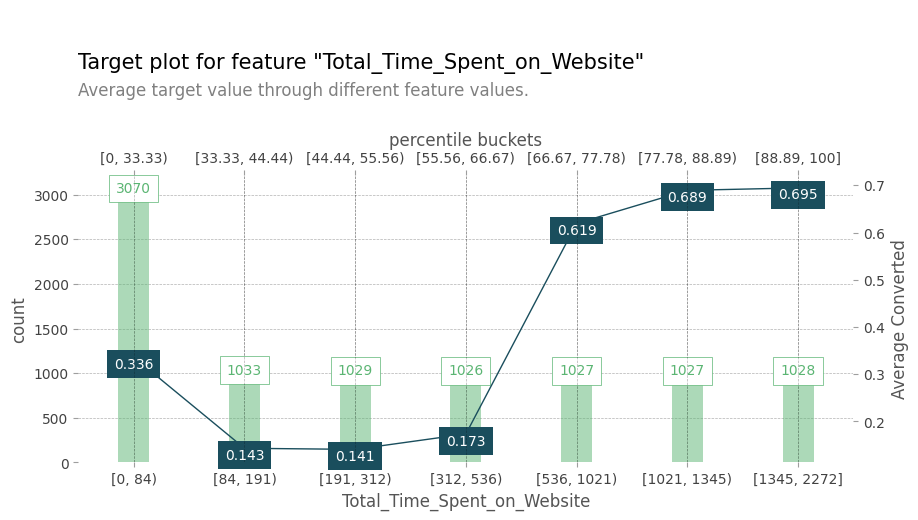

In [ ]:
# target distribution through feature 'Total_Time_Spent_on_Website'
fig, axes, summary_df = info_plots.target_plot(
    
                                               df=leads_c, 
                                               feature='Total_Time_Spent_on_Website', 
                                               feature_name='Total_Time_Spent_on_Website', 
                                               target="Converted", 
                                               show_percentile=True,
                                               figsize = (10,6)

                                               )

In [ ]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,Converted
0,0,"[0, 84)",0.0,84.0,"[0, 33.33)",0.00,33.33,3070,0.336156
1,1,"[84, 191)",84.0,191.0,"[33.33, 44.44)",33.33,44.44,1033,0.143272
2,2,"[191, 312)",191.0,312.0,"[44.44, 55.56)",44.44,55.56,1029,0.140914
3,3,"[312, 536)",312.0,536.0,"[55.56, 66.67)",55.56,66.67,1026,0.173489
4,4,"[536, 1021)",536.0,1021.0,"[66.67, 77.78)",66.67,77.78,1027,0.619279
5,5,"[1021, 1345)",1021.0,1345.0,"[77.78, 88.89)",77.78,88.89,1027,0.689387
6,6,"[1345, 2272]",1345.0,2272.0,"[88.89, 100]",88.89,100.00,1028,0.694553


## check prediction distribution through feature 'Total_Time_Spent_on_Website'

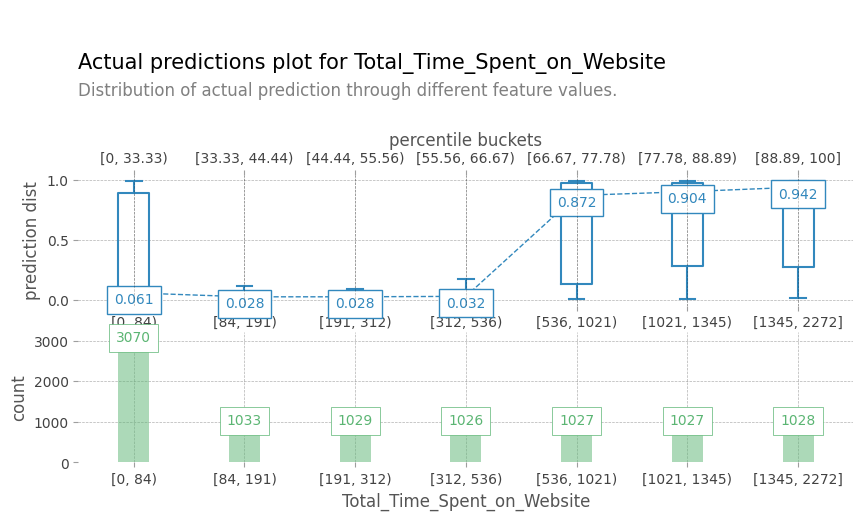

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model, X=X, feature='Total_Time_Spent_on_Website', feature_name='Total_Time_Spent_on_Website', 
    show_percentile=True, predict_kwds={}, figsize = (10,6)
)

In [ ]:
# pdp for feature 'Tags'
pdp_fare = pdp.pdp_isolate(
    model=model, dataset=X, model_features=X.columns, feature='Tags'
)

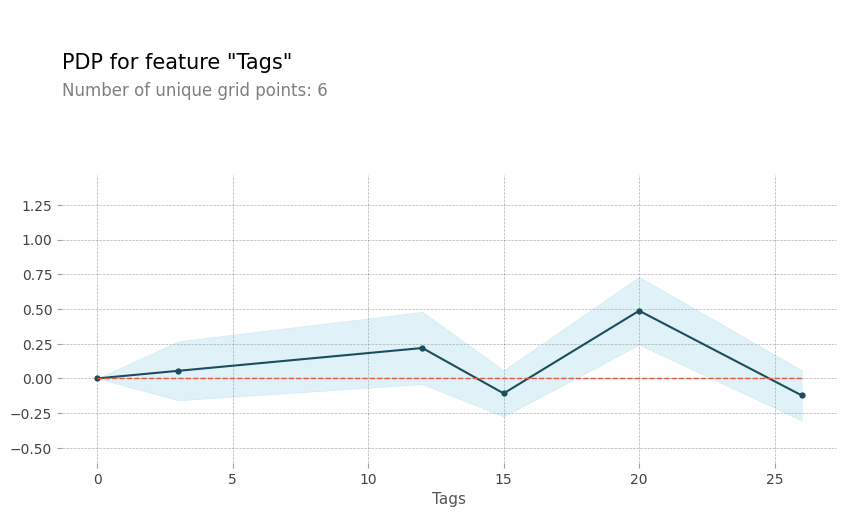

In [ ]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Tags', figsize = (10,6))

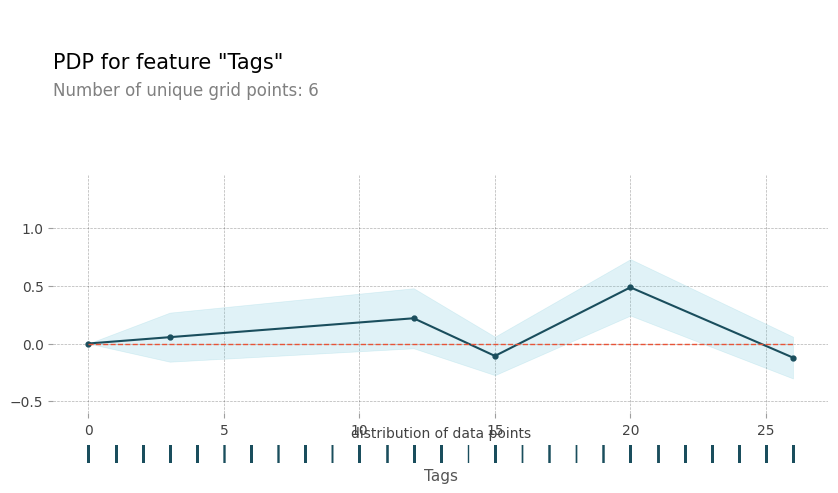

In [ ]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Tags', plot_pts_dist=True, figsize = (10,6))

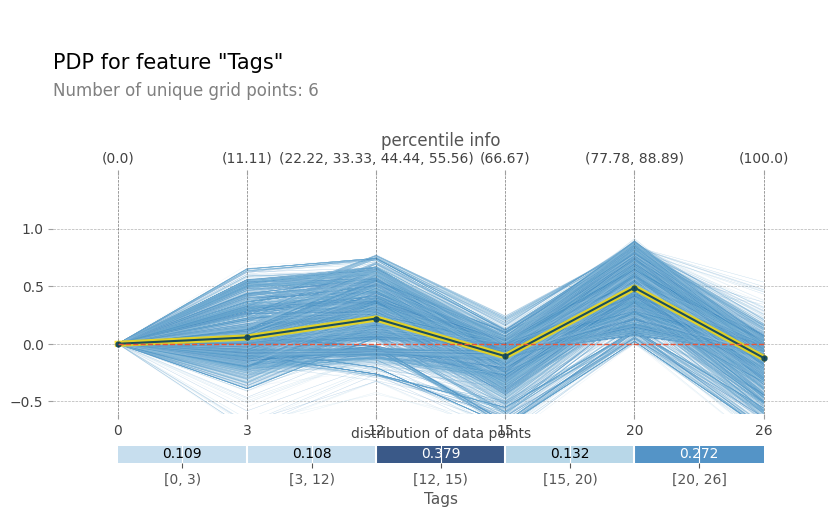

In [ ]:
fig, axes = pdp.pdp_plot(
    pdp_fare, 'Tags', frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True, figsize = (10,6)
)

## Interaction between two variables

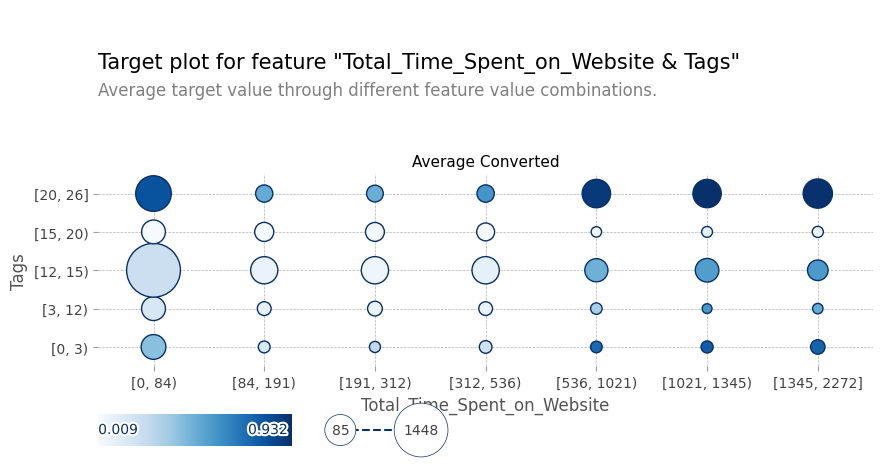

In [ ]:

#  target distribution through feature combination of "Total_Time_Spent_on_Website", "Tags"
fig, axes, summary_df = info_plots.target_plot_interact(
    df=leads_c, features=["Total_Time_Spent_on_Website", "Tags"], feature_names=["Total_Time_Spent_on_Website", "Tags"], target="Converted", figsize = (10,6)
)

In [ ]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,value_lower_2,value_upper_2,count,Converted
0,0,0,"[0, 84)","[0, 3)",0.0,84.0,0.0,3.0,336,0.401786
1,0,1,"[0, 84)","[3, 12)",0.0,84.0,3.0,12.0,316,0.155063
2,0,2,"[0, 84)","[12, 15)",0.0,84.0,12.0,15.0,1448,0.213398
3,0,3,"[0, 84)","[15, 20)",0.0,84.0,15.0,20.0,314,0.019108
4,0,4,"[0, 84)","[20, 26]",0.0,84.0,20.0,26.0,656,0.812500


## prediction distribution through feature combination

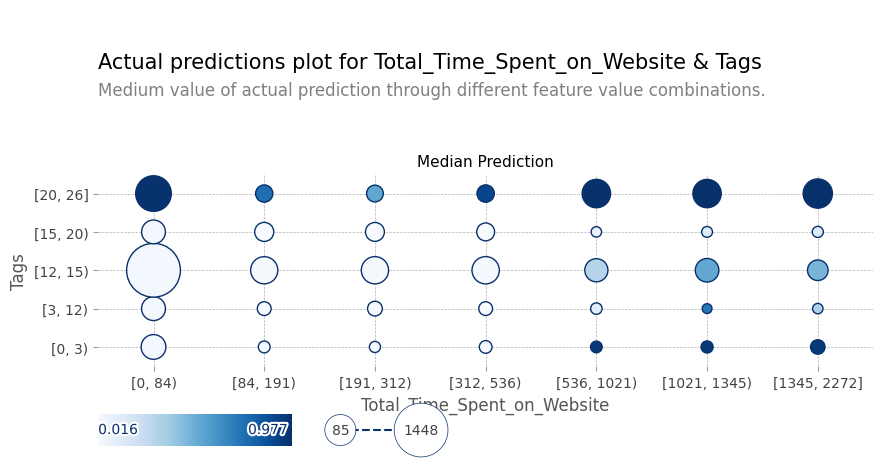

In [ ]:

fig, axes, summary_df = info_plots.actual_plot_interact(
    model=model, X=X, features=["Total_Time_Spent_on_Website", "Tags"], feature_names=["Total_Time_Spent_on_Website", "Tags"], figsize = (10,6)
)

## pdp for feature combination

In [ ]:
inter1 = pdp.pdp_interact(
    model=model, dataset=leads_c, model_features=X.columns, features=["Total_Time_Spent_on_Website", "Tags"]
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


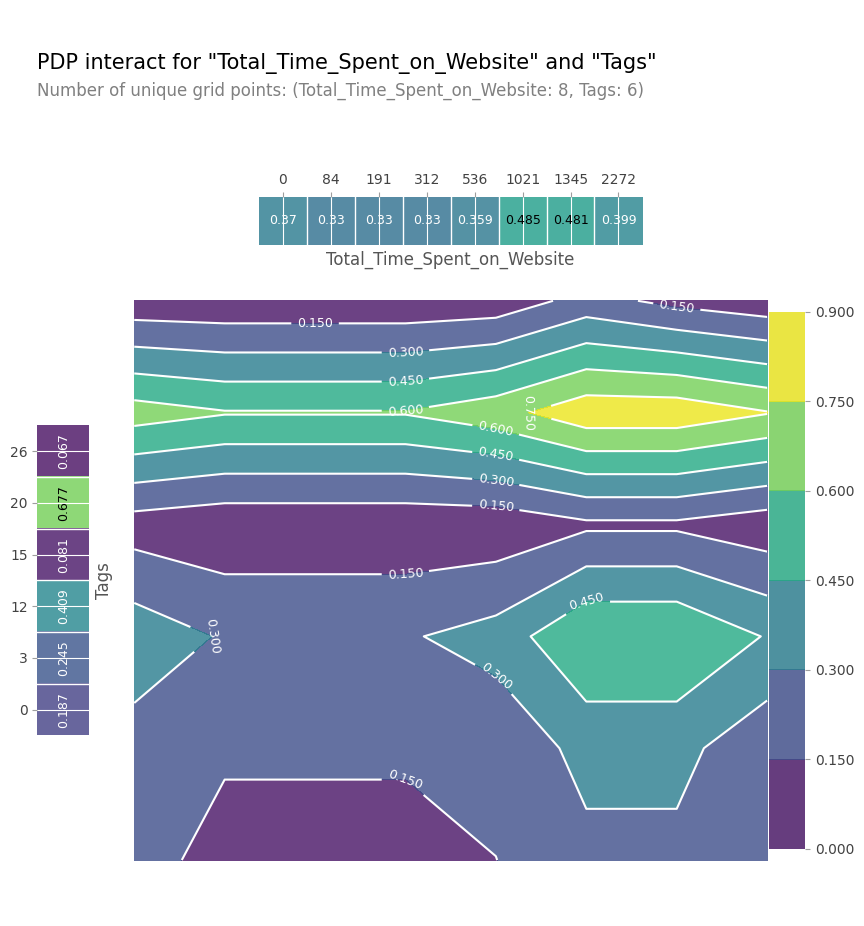

In [ ]:
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=["Total_Time_Spent_on_Website", "Tags"], plot_type='contour', x_quantile=True, plot_pdp=True, figsize = (10,12)
)

## Feature Drift

In [ ]:
drift_template = """<!DOCTYPE html>
<html>

<head>
    <meta charset='utf-8' />
    <script src="https://d3js.org/d3.v3.min.js" charset="utf-8"></script>
    <style>
        body {
            font-family: "Arial", sans-serif;
            margin: 60px 50px 50px 100px;
        }
    </style>
</head>

<body>
    <div>
        <h1>Feature Drift</h1>
        <p>Visualize how important features drift through two datasets.</p>
    </div>
    <div id="legend"></div> 
    <div id="graphic"></div>

    <script>
        // variables
        var bar_left_data = {{ bar_left_data|safe }},
            bar_right_data = {{ bar_right_data|safe }},
            line_data = {{ line_data|safe }}, 
            legend_data = {{ legend_data|safe }},
            max_bar_width = {{ max_bar_width }},
            bar_height = {{ bar_height }},
            middle_gap = {{ middle_gap }},
            fontsize = {{ fontsize }}, 
            ds_name1 = '{{ ds_name1 }}', 
            ds_name2 = '{{ ds_name2 }}';

        var width = max_bar_width * 2 + middle_gap,
            height = bar_left_data.length * bar_height;

        // bars
        var svg = d3.select("#graphic").append("svg")
            .attr("width", width + 10)
            .attr("height", height + 10)
            .append("g");

        // scaler for bar width
        var x = d3.scale.linear()
            .range([0, max_bar_width])
            .domain([0, 1.0]);

        // scaler for bar height
        var y_left = d3.scale.ordinal()
                .rangeRoundBands([0, height], .1)
                .domain(bar_left_data.map(function (d) {
                    return d.feat_name;
                }));

        var y_right = d3.scale.ordinal()
                .rangeRoundBands([0, height], .1)
                .domain(bar_right_data.map(function (d) {
                    return d.feat_name;
                }));

        // adjust for titles
        var title_adjust = bar_height - y_left(bar_left_data[0].feat_name);

        // draw legends
        var legend_height = bar_height / 1.5,
            legend_gap = 3,
            legend_text_offset_x = 5,
            legend_text_offset_y = 4,
            legend_margin_bottom = bar_height;

        var legend = d3.select('#legend').append('svg')
            .attr("width", width + 10)
            .attr("height", legend_height * 2 + legend_gap + legend_margin_bottom)
            .append("g");

        var legend_bars = legend.selectAll('.legend_bar')
            .data(legend_data)
            .enter()
            .append("g")

        legend_bars.append("rect")
            .attr("class", 'legend_bar')
            .attr("y", function (d, i) {
                if (i >= 2) {
                    return legend_height + legend_gap;
                }else{
                    return 0;
                }
            })
            .attr("height", legend_height)
            .attr("x", function(d, i) {
                return (max_bar_width / 2.) * (i % 2);
            })
            .attr("width", legend_height)
            .style("fill", function(d) {
                return d.color;
            });

        legend_bars.append("text")
            .attr("class", "legend_label")
            .attr("y", function (d, i) {
                if (i >= 2) {
                    return 1.5 * legend_height + legend_gap + legend_text_offset_y;
                }else{
                    return 0.5 * legend_height + 4;
                }
            })
            .attr("x", function(d, i) {
                return (max_bar_width / 2.) * (i % 2) + legend_height + legend_text_offset_x;
            })
            .text(function (d) {
                return d.name;
            })
            .style('font-size', fontsize + 'px')
            .style('font-weight', 'bold');

        // draw bars and lines
        updateBar('left', bar_left_data);
        updateBar('right', bar_right_data);
        updateLines();

        function updateBar(pos, bar_data) {

            var bar_x = 0,
                bg_bar_class = 'bg_bar_left',
                bar_class = 'bar_left',
                y = y_left, 
                other_pos = 'right', 
                title = ds_name1;

            if (pos == 'right') {
                bar_x = max_bar_width + middle_gap;
                bg_bar_class = 'bg_bar_right';
                bar_class = 'bar_right';
                y = y_right;
                other_pos = 'left', 
                title = ds_name2;
            }

            // append title
            svg.append("g").append('text')
                .text(title)
                .attr('y', bar_height / 1.5)
                .attr('x', bar_x + 5)
                .style('fill', '#000')
                .style('font-weight', 'bold')
                .style('font-size', fontsize + 2 + 'px');
            
            // draw gray bars as background
            var bg_bars = svg.selectAll("." + bg_bar_class)
                .data(bar_data)
                .enter()
                .append("g")

            bg_bars.append("rect")
                .attr("class", bg_bar_class)
                .attr("y", function (d) {
                    return y(d.feat_name) + title_adjust;
                })
                .attr("height", y.rangeBand())
                .attr("x", bar_x)
                .attr("width", max_bar_width)
                .style("fill", '#f0f0f0')
                .on("mouseover", barHover)
                .on("mouseout", barOut);

            // draw bars
            var bars = svg.selectAll("." + bar_class)
                .data(bar_data)
                .enter()
                .append("g");

            bars.append("rect")
                .attr("class", bar_class)
                .attr("y", function (d) {
                    return y(d.feat_name) + title_adjust;
                })
                .attr("height", y.rangeBand())
                .attr("x", bar_x)
                .attr("width", function (d) {
                    return x(d.relative_imp);
                })
                .style('fill', function (d){
                    return d.bar_color;
                })                
                .on("mouseover", barHover)
                .on("mouseout", barOut);

            // append feature names
            bars.append("text")
                .attr("class", "label")
                .attr("y", function (d) {
                    return y(d.feat_name) + y.rangeBand() / 1.5 + title_adjust;
                })
                .attr("x", bar_x+5)
                .text(function (d) {
                    return d.feat_name;
                })
                .style('fill', function(d) { return '#000';})
                .style('font-size', fontsize + 'px');
        }


        function updateLines() {

            var lines = svg.selectAll(".lines")
                .data(line_data)
                .enter()
                .append("g");

            lines.append("line")
                .attr("class", "lines")
                .attr('x1', max_bar_width)
                .attr('y1', function (d) {
                    return y_left(d.feat_name) + y_left.rangeBand() / 2 + title_adjust;
                })
                .attr('x2', max_bar_width + middle_gap)
                .attr('y2', function (d) {
                    return y_right(d.feat_name) + y_right.rangeBand() / 2 + title_adjust;
                })
                .style('stroke', function (d) {
                    return d.bar_color;
                });

        }

        // mouseover handler
        function barHover(d) {
            d3.selectAll('.bg_bar_' + d.pos).filter(function(o) {
                return o.feat_name == d.feat_name;
            })
            .style("stroke", d.bar_color)
            .style("stroke-width", 2);

            var other_pos = 'right';
            if (d.pos == 'right') other_pos = 'left';

            if (d.bar_mark == '1') {
                d3.selectAll('.bg_bar_' + other_pos).filter(function(o) {
                    return o.feat_name == d.feat_name;
                })
                .style("stroke", d.bar_color)
                .style("stroke-width", 2);

                d3.selectAll('.lines').filter(function(l) {
                    return l.feat_name == d.feat_name;
                })
                .style("stroke-width", 4);
            }
        }

        // mouseout handler
        function barOut(d) {

            d3.selectAll('.bg_bar_' + d.pos).filter(function(o) {
                return o.feat_name == d.feat_name;
            })
            .style("stroke", null);

            var other_pos = 'right';
            if (d.pos == 'right') other_pos = 'left';

            if (d.bar_mark == '1') {
                d3.selectAll('.bg_bar_' + other_pos).filter(function(o) {
                    return o.feat_name == d.feat_name;
                })
                .style("stroke", null);

                d3.selectAll('.lines').filter(function(l) {
                    return l.feat_name == d.feat_name;
                })
                .style("stroke-width", 1);
            }
        }

    </script>
</body>
</html>
"""

In [ ]:
import pandas as pd
import jinja2
import os


def _process_imp(imp_df, imp_name):
    """
    Preprocessing on the input feature importance dataframe
    :param imp_df: feature importance pandas dataframe
    :param imp_name: column name of the importance value
    :return:
        dataframe with relative_imp and feat_rank
    """

    imp_df = imp_df.sort_values(by=imp_name, ascending=False).reset_index(drop=True)
    imp_df['relative_imp'] = imp_df[imp_name] * 1.0 / imp_df[imp_name].max()
    imp_df['relative_imp'] = imp_df['relative_imp'].apply(lambda x : round(x, 3))
    imp_df['feat_rank'] = imp_df.index.values + 1
    return imp_df


def _rank2color(x, color_dict):
    """
    Map change of rank to color
    :param x: row of dataframe
    :param color_dict: color dictionary
    """

    if x['feat_rank_x'] < x['feat_rank_y']:
        return color_dict['drop']
    if x['feat_rank_x'] >= x['feat_rank_y']:
        return color_dict['up_or_stable']
    if pd.isnull(x['feat_rank_y']):
        return color_dict['disappear']
    if pd.isnull(x['feat_rank_x']):
        return color_dict['appear']
    

def _get_mark(x):
    """
    '1' for feature appears on both feature importance dataframes
    '0' for feature disappears on either dataframe
    """
    if pd.isnull(x['feat_rank_y']) or pd.isnull(x['feat_rank_x']):
        return "0"
    else:
        return "1"
    

def _merge_feat_imp(imp_df1, imp_df2, feature_name, top_n, color_dict):
    """
    Merge and compare two feature importance dataframes
    :param imp_df1: feature importance dataframe #1
    :param imp_df2: feature importance dataframe #2
    :param feature_name: column name of features
    :param top_n: show top_n features
    :param color_dict: color dictionary
    :return:
        The merged dataframe
    """

    imp_df1['pos'] = 'left'
    imp_df2['pos'] = 'right'
    if top_n:
        both_imp = imp_df1.head(top_n).merge(imp_df2.head(top_n), on=feature_name, how='outer')
    else:
        both_imp = imp_df1.merge(imp_df2, on=feature_name, how='outer')
        
    both_imp['bar_color'] = both_imp.apply(lambda x : _rank2color(x, color_dict), axis=1)
    both_imp['bar_mark'] = both_imp.apply(lambda x : _get_mark(x), axis=1)
    
    return both_imp


def feature_drift_graph(feat_imp1, feat_imp2, feature_name, imp_name, ds_name1, ds_name2, graph_name=None,
                        top_n=None, max_bar_width=300, bar_height=30, middle_gap=300, fontsize=12, color_dict=None):
    """
    Draw feature drift graph
    :param feat_imp1: feature importance dataframe #1
    :param feat_imp2: feature importance dataframe #2
    :param feature_name: column name of features
    :param imp_name: column name of importance value
    :param ds_name1: name of dataset #1
    :param ds_name2: name of dataset #2
    :param top_n: show top_n features
    :param max_bar_width: maximum bar width
    :param bar_height: bar height
    :param middle_gap: gap between bars
    :param fontsize: font size
    :param color_dict: color dictionary
    """

    feat_imp1 = _process_imp(feat_imp1, imp_name)
    feat_imp2 = _process_imp(feat_imp2, imp_name)
    
    if color_dict is None:
        color_dict = {
            'drop': '#f17182',
            'up_or_stable': '#abdda4',
            'disappear': '#bababa',
            'appear': '#9ac6df'
        }
    
    both_imp = _merge_feat_imp(feat_imp1, feat_imp2, feature_name, top_n, color_dict)
    
    bar_left_data = both_imp[['feat_name', 'relative_imp_x', 'pos_x', 'bar_color', 'bar_mark']
                            ].dropna().sort_values('relative_imp_x', ascending=False)
    bar_left_data.columns = [col.replace('_x', '') for col in bar_left_data.columns.values]

    bar_right_data = both_imp[['feat_name', 'relative_imp_y', 'pos_y', 'bar_color', 'bar_mark']
                             ].dropna().sort_values('relative_imp_y', ascending=False)
    bar_right_data.columns = [col.replace('_y', '') for col in bar_right_data.columns.values]

    line_data = both_imp[['feat_name', 'bar_color', 'feat_rank_x', 'feat_rank_y']].dropna()[['feat_name', 'bar_color']]
    
    legend_data = [
        {'name': 'Drop', 'color': color_dict['drop']},
        {'name': 'Up & Stable', 'color': color_dict['up_or_stable']},
        {'name': 'Disappear', 'color': color_dict['disappear']},
        {'name': 'Appear', 'color': color_dict['appear']}
    ]
    
    with open('feature_drift_template.html', 'w') as f:
        f.write(drift_template)

    # render the output
    temp = open('feature_drift_template.html').read()
    # temp = open('https://raw.githubusercontent.com/SauceCat/Nuance/master/feat_drift/src/feature_drift_template.html').read()

    template = jinja2.Template(temp)

    # create the output root if it is not exits
    if not os.path.exists('feature_drift_output'):
        os.mkdir('feature_drift_output')

    # generate output html
    if graph_name is None:
        output_path = 'feature_drift_output.html'
    else:
        output_path = 'feature_drift_%s.html' %graph_name

    with open(output_path, 'w') as fh:
        fh.write(template.render({'bar_left_data': bar_left_data.to_dict('records'), 
                                  'bar_right_data': bar_right_data.to_dict('records'), 
                                  'line_data': line_data.to_dict('records'), 
                                  'legend_data': legend_data, 
                                  'max_bar_width': max_bar_width, 'bar_height': bar_height, 
                                  'middle_gap': middle_gap, 'fontsize': fontsize,
                                  'ds_name1': ds_name1, 'ds_name2': ds_name2}))

In [ ]:
etc_imp = multivarFS[['Feature', 'ETC_Importance']]
xgb_imp = multivarFS[['Feature', 'Xgb_Importance']]

etc_imp.rename(columns={'Feature': 'feat_name', 'ETC_Importance':'imp'}, inplace=True)
xgb_imp.rename(columns={'Feature': 'feat_name', 'Xgb_Importance':'imp'}, inplace=True)

In [ ]:
xgb_imp.columns

Index(['feat_name', 'imp'], dtype='object')

In [ ]:

feature_drift_graph(feat_imp1=etc_imp, 
                    feat_imp2=xgb_imp, 
                    feature_name='feat_name', 
                    imp_name='imp',
                    ds_name1='ExtraTreeClassifier', 
                    ds_name2='XGBClassifier', 
                    graph_name='ETC_XGB',
                    top_n=20, 
                    max_bar_width=300, 
                    bar_height=30, 
                    middle_gap=300, 
                    fontsize=12, 
                    color_dict=None)

In [ ]:
# from IPython.display import IFrame
# IFrame(src='feature_drift_ETC_XGB.html', width=700, height=600)

from IPython.display import HTML
# HTML(filename="feature_drift_ETC_XGB.html")


# SkopeRules

In [ ]:


def compute_y_pred_from_query(X, rule):
    score = np.zeros(X.shape[0])
    X = X.reset_index(drop=True)
    score[list(X.query(rule).index)] = 1
    return (score)

def compute_performances_from_y_pred(y_true, y_pred, index_name='default_index'):
    df = pd.DataFrame(data=
        {
            'precision':[sum(y_true * y_pred)/sum(y_pred)],
            'recall':[sum(y_true * y_pred)/sum(y_true)]
        },
        index=[index_name],
        columns=['precision', 'recall']
    )
    return (df)

def compute_train_test_query_performances(X_train, y_train, X_test, y_test, rule):
    
    y_train_pred = compute_y_pred_from_query(X_train, rule)
    y_test_pred = compute_y_pred_from_query(X_test, rule)
    
    performances = None
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_train, y_train_pred, 'train_set')],
        axis=0)
    
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_test, y_test_pred, 'test_set')],
        axis=0)
            
    return (performances)


def plot_roc_precison_recall(y_true, 
                             scores_with_line=[], 
                             scores_with_points=[],
                             labels_with_line=['Gradient Boosting', 'Random Forest', 'Decision Tree'],
                             labels_with_points=['skope-rules']):
    
    gradient = np.linspace(0, 1, 10)
    color_list = [ cm.tab10(x) for x in gradient ]
    # print(color_list)

    # c=color.reshape(1,-1) -reshape or transpose list

    fig, axes = plt.subplots(1, 
                             2, 
                             figsize=(12, 5), 
                             sharex=True, 
                             sharey=True)
    ax = axes[0]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.plot(fpr, 
                tpr, 
                linestyle='-.', 
                linewidth=2,
                c=color_list[i_score], 
                lw=1, 
                label=labels_with_line[i_score])
        
    for i_score, score in enumerate(scores_with_points):
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.scatter(fpr[:-1], 
                   tpr[:-1], 
                   c=color_list[n_line + i_score], 
                   s=30, 
                   label=labels_with_points[i_score])
        
    ax.set_title("ROC", fontsize=18)
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=16)
    ax.legend(loc='lower center', fontsize=8)

    ax = axes[1]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.step(recall, 
                precision, 
                linestyle='-.', 
                linewidth=2,
                c=color_list[i_score], 
                lw=1, 
                where='post', 
                label=labels_with_line[i_score])
        
    for i_score, score in enumerate(scores_with_points):
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.scatter(recall, 
                   precision, 
                   c=color_list[n_line + i_score], 
                   s=30, 
                   label=labels_with_points[i_score])
        
    ax.set_title("Precision-Recall", fontsize=18)
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=16)
    ax.set_ylabel('Precision', fontsize=16)
    ax.legend(loc='lower center', fontsize=8)
    plt.show()
    
    


def skopeRuleFit(df, target):

    # Rename columns with "space" to "_"
    df.columns = [i.replace(' ','_') for i in df.columns]

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.33, 
                                                        random_state = 42)



    # Train a gradient boosting classifier for benchmark
    gradient_boost_clf = GradientBoostingClassifier(random_state=42, n_estimators=30, max_depth = 5)
    gradient_boost_clf.fit(X_train, y_train)

    # Train a random forest classifier for benchmark
    random_forest_clf = RandomForestClassifier(random_state=42, n_estimators=30, max_depth = 5)
    random_forest_clf.fit(X_train, y_train)

    # Train a decision tree classifier for benchmark
    decision_tree_clf = DecisionTreeClassifier(random_state=42, max_depth = 5)
    decision_tree_clf.fit(X_train, y_train)

    feature_names = X_train.columns

    # Train a skope-rules-boosting classifier
    skope_rules_clf = SkopeRules(feature_names=feature_names, random_state=42, n_estimators=30,
                                recall_min=0.05, precision_min=0.9,
                                max_samples=0.7,
                                max_depth_duplication= 4, max_depth = 5)
    skope_rules_clf.fit(X_train, y_train)


    # Compute prediction scores
    gradient_boost_scoring = gradient_boost_clf.predict_proba(X_test)[:, 1]
    random_forest_scoring = random_forest_clf.predict_proba(X_test)[:, 1]
    decision_tree_scoring = decision_tree_clf.predict_proba(X_test)[:, 1]

    skope_rules_scoring = skope_rules_clf.score_top_rules(X_test)
    # print(f"Skope rules Scoring{skope_rules_scoring}")
    # print(f"SkopeRules Classifier{skope_rules_clf}")

    # Get number of target rules created
    print(str(len(skope_rules_clf.rules_)) + ' rules have been built with ' + 'SkopeRules.\n')

    skope_rule_listuple = skope_rules_clf.rules_
    # Print SkopeRules
    for i in skope_rule_listuple:
        print(f"{bcolors.LightBlue}=={bcolors.ResetAll}"*40)
        print(f"{bcolors.Magenta}{i}{bcolors.ResetAll}")

    # Print Train Test Query Performances
    for i in range(len(skope_rule_listuple)):
        print('Rule '+str(i+1)+':')
        display(compute_train_test_query_performances(X_train, 
                                                      y_train,
                                                      X_test, 
                                                      y_test,
                                                      skope_rules_clf.rules_[i][0]
                                                      )
        )
    
    
    # Plot ROC Curve & Precison-Recall
    plot_roc_precison_recall(y_test,
                            scores_with_line = [gradient_boost_scoring, random_forest_scoring, decision_tree_scoring],
                            scores_with_points=[skope_rules_scoring]
                            )

10 rules have been built with SkopeRules.

('Tags <= 20.5 and Tags > 19.5 and Lead_Quality <= 2.5 and What_is_your_current_occupation > 0.5', (0.9743394678450896, 0.5297257091433346, 4))
('Tags <= 21.5 and Tags > 19.5 and Lead_Quality <= 2.5 and Asymmetrique_Activity_Score <= 16.5 and TotalVisits > -499.5', (0.9780346820809248, 0.5251396648044693, 2))
('Tags <= 21.5 and Tags > 19.5 and Lead_Quality <= 2.5 and Last_Notable_Activity <= 11.0 and What_is_your_current_occupation > 0.5', (0.9459459459459459, 0.2764277035236938, 2))
('Tags <= 21.5 and Tags > 19.5 and Lead_Quality <= 2.5 and Last_Notable_Activity > 9.5', (0.9977383772971189, 0.26736462974022723, 8))
('Tags <= 20.5 and Tags > 19.5 and Lead_Quality <= 2.5 and Last_Notable_Activity > 11.0 and What_is_your_current_occupation > 0.5', (0.9975609756097561, 0.2512285012285012, 2))
('Tags <= 21.5 and Tags > 19.5 and Lead_Quality <= 2.5 and Last_Notable_Activity <= 9.5 and Total_Time_Spent_on_Website > 395.0', (0.9737704918032787, 0.178

,precision,recall
train_set,0.975743,0.528614
test_set,0.971787,0.515807


Rule 2:


,precision,recall
train_set,0.978469,0.520136
test_set,0.972843,0.506656


Rule 3:


,precision,recall
train_set,0.953800,0.271301
test_set,0.949405,0.265391


Rule 4:


,precision,recall
train_set,0.996820,0.265791
test_set,0.993711,0.262895


Rule 5:


,precision,recall
train_set,0.998361,0.258160
test_set,0.996689,0.250416


Rule 6:


,precision,recall
train_set,0.976636,0.177194
test_set,0.985000,0.163894


Rule 7:


,precision,recall
train_set,0.909804,0.098347
test_set,0.898438,0.095674


Rule 8:


,precision,recall
train_set,0.959064,0.069521
test_set,0.921739,0.088186


Rule 9:


,precision,recall
train_set,0.880952,0.062738
test_set,0.887640,0.065724


Rule 10:


,precision,recall
train_set,0.938776,0.058499
test_set,0.912621,0.078203


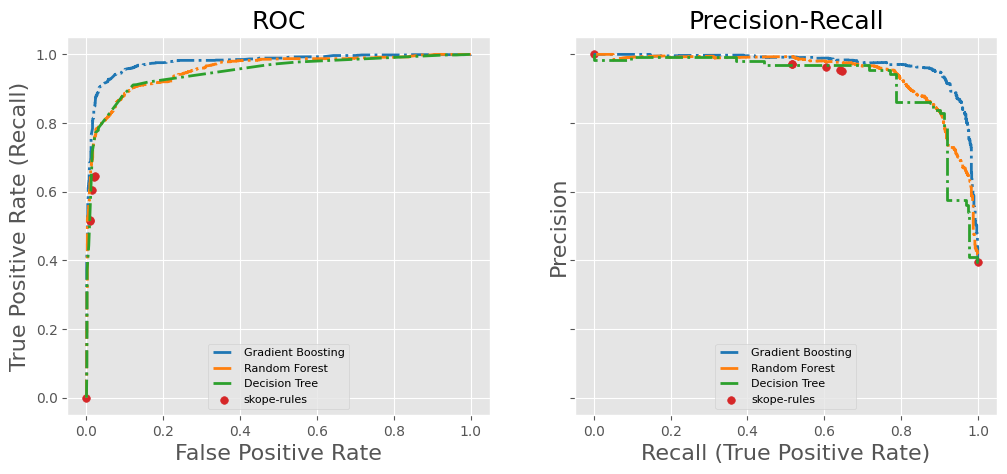

CPU times: user 9.94 s, sys: 102 ms, total: 10 s
Wall time: 10.1 s


In [ ]:
%%time
skopeRuleFit(leads_c, "Converted")

# RuleFit

In [ ]:
def friedmansRuleFit(df, target):
    """
           Impliments  Friedman's RuleFit
           https://christophm.github.io/interpretable-ml-book/rulefit.html

    
    Params
    ================================
    df          : A dataframe
    target      : target column name(str)

    Returns
    =====================================
    rules       : Rules generated using RuleFit
    """
    

    X = df.drop(target, axis=1)

    features = X.columns

    X = X.to_numpy()
    y = df[target].values

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.33, 
                                                        random_state = 42)
    
    
    

    # RuleFit Regressor Performance Against Other Algorithms
    model_dict = {
        'Gradient Boosted Classifier': GradientBoostingClassifier(),
        'Random Forest Classifier':RandomForestClassifier(),
        'Decision Tree Classifier':DecisionTreeClassifier(),
        'Logistic Regression':LogisticRegression(),
        'RuleFit Classifier':RuleFit(tree_size=4,
                                     sample_fract='default',
                                     max_rules=500,
                                     memory_par=0.01,
                                     tree_generator=None,
                                     rfmode='classify',
                                     lin_trim_quantile=0.025,
                                     lin_standardise=True, 
                                     exp_rand_tree_size=True,
                                     random_state=1) 
        }

    test_results = {}

    for model in model_dict.keys():
        if model == 'RuleFit Classifier':
            model_dict[model].fit(X_train,y_train, feature_names = features)
        else:
            model_dict[model].fit(X_train,y_train)
        r2 = f1_score(y_test, model_dict[model].predict(X_test))
        test_results.update({model:np.round(r2,2)})

    display(pd.DataFrame(data = test_results.values(),
             index = test_results.keys(),
             columns = ['F1-Score']).sort_values(by='F1-Score',ascending=False))
    
    # While not the best, we can see that the RuleFit Regressor performs similarly to other algorithms.

    # RuleFit Interpretations
    rf = model_dict['RuleFit Classifier']
    rules = rf.get_rules()

    display(rules[rules.coef!=0].sort_values(by='importance', ascending=False).head(10))

    num_rules_rule = len(rules[rules.type=='rule'])
    num_rules_linear = len(rules[rules.type=='linear'])

    print(f"{bcolors.LightBlue}=={bcolors.ResetAll}"*40)
    print(f"{bcolors.Magenta}Number of Linear Rules Generated         :{num_rules_linear}{bcolors.ResetAll}")
    print(f"{bcolors.Magenta}Number of Rules Generated                :{num_rules_rule}{bcolors.ResetAll}")
    print(f"{bcolors.LightBlue}=={bcolors.ResetAll}"*40)

    return rules

In [ ]:
%%time
rules = friedmansRuleFit(leads_c, "Converted")


,F1-Score
Gradient Boosted Classifier,0.93
Random Forest Classifier,0.91
RuleFit Classifier,0.89
Decision Tree Classifier,0.88
Logistic Regression,0.75


,rule,type,coef,support,importance
250,Tags <= 19.5 & Tags > 12.5,rule,-3.057016,0.159091,1.118137
11,Tags,linear,0.137994,1.000000,0.850270
10,What_matters_most_to_you_in_choosing_a_course,linear,-0.917753,1.000000,0.836246
277,Tags > 18.5 & Tags > 13.5 & Last_Notable_Activity > 11.0 & Tags <= 21.5,rule,2.234922,0.132867,0.758602
183,Tags <= 19.5 & Tags <= 3.0 & Lead_Quality <= 2.5 & Tags > 1.5,rule,3.389193,0.027972,0.558853
19,Last_Notable_Activity,linear,-0.169875,1.000000,0.523170
177,Tags > 18.0 & Tags > 20.5,rule,-1.645958,0.062937,0.399721
237,Last_Activity <= 12.0 & Lead_Quality > 2.5 & Asymmetrique_Activity_Score <= 14.5,rule,-0.773478,0.396853,0.378420
266,Tags > 0.5 & Total_Time_Spent_on_Website > 560.5,rule,0.795131,0.314685,0.369251
297,Lead_Quality > 2.5 & Tags > 12.5,rule,-0.789605,0.192308,0.311194


Number of Linear Rules Generated         :20
Number of Rules Generated                :298
CPU times: user 39.4 s, sys: 626 ms, total: 40 s
Wall time: 39.3 s


In [ ]:
# pd.set_option('display.max_colwidth', None)

In [ ]:
# rules

In [ ]:
# rules[rules.importance > 0.0]

In [ ]:
# num_rules_rule = len(rules[rules.type=='rule'])
# num_rules_linear = len(rules[rules.type=='linear'])

In [ ]:
# rules[rules.type=='linear']

In [ ]:
# num_rules_rule

In [ ]:
# num_rules_linear

In [ ]:
# leads_c.columns[0:-1]

In [ ]:
X = leads_c.drop("Converted", axis=1)
y = leads_c["Converted"]


    

In [ ]:
# Plots at Various Levels

# Microsoft Errror Analysis

# Rules
#        - SkopeRules
#        - RuleFit


# Genetic Theory
# Particle Swarm Optimization

# Roashman Effect


# Decision Boundary

# Decision Boundary for Important Features

https://github.com/tmadl/highdimensional-decision-boundary-plot

https://stackoverflow.com/questions/37718347/plotting-decision-boundary-for-high-dimension-data

https://github.com/PanWu/pylib/blob/master/pylib/plot.py

https://deslib.readthedocs.io/en/latest/auto_examples/plot_example_P2.html

In [ ]:
# sample_list = ufs_df[ufs_df.ppscore > 0]["x"].to_list()
sample_list = ['Tags', 'Lead_Quality', 'Lead_Profile', 'Total_Time_Spent_on_Website']

In [ ]:
decision_boundary_df(leads_c, "Converted", sample_list, GradientBoostingClassifier)

['Lead_Profile', 'Total_Time_Spent_on_Website']
['Tags', 'Lead_Profile']
['Tags', 'Total_Time_Spent_on_Website']


In [ ]:
imp_pairs = uniqueCombinations(sample_list)
for i in imp_pairs:
    print(list(i))
    plot_decision_boundaries(leads_c, "Converted", list(i), GradientBoostingClassifier)

['Lead_Quality', 'Total_Time_Spent_on_Website']
['Tags', 'Total_Time_Spent_on_Website']


In [ ]:
plot_decision_boundaries(leads_c, "Converted", ['Tags', 'Total_Time_Spent_on_Website'], GradientBoostingClassifier)

In [ ]:

def plot_decision_boundaries(df, target, feats, model_class, **model_params):
    """
    Function to plot the decision boundaries of a classification model.
    This uses just the first two columns of the data for fitting 
    the model as we need to find the predicted value for every point in 
    scatter plot.
    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model_class: A Scikit-learn ML estimator class 
            e.g. GaussianNB (imported from sklearn.naive_bayes) or
            LogisticRegression (imported from sklearn.linear_model)
            **model_params: Model parameters to be passed on to the ML estimator
    
    Typical code example:
            plt.figure()
            plt.title("KNN decision boundary with neighbros: 5",fontsize=16)
            plot_decision_boundaries(X_train,y_train,KNeighborsClassifier,n_neighbors=5)
            plt.show()
    """

    X = df[feats]
    y = df[target]

    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")
    # Reduces to the first two columns of data
    # reduced_data = X[:, :2]
    # Instantiate the model object
    model = model_class(**model_params)
    # Fits the model with the reduced data
    model.fit(X, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(num=None, figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k')

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

    plt.xlabel(feats[0],fontsize=15)
    plt.ylabel(feats[1],fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    

    plt.show()



In [ ]:
plot_decision_boundaries

In [ ]:
X.columns

Index(['Lead_Origin', 'Lead_Source', 'Do_Not_Email', 'TotalVisits',
       'Total_Time_Spent_on_Website', 'Last_Activity', 'Country',
       'Specialization', 'How_did_you_hear_about_X_Education',
       'What_is_your_current_occupation',
       'What_matters_most_to_you_in_choosing_a_course', 'Tags', 'Lead_Quality',
       'Lead_Profile', 'City', 'Asymmetrique_Activity_Index',
       'Asymmetrique_Profile_Index', 'Asymmetrique_Activity_Score',
       'A_free_copy_of_Mastering_The_Interview', 'Last_Notable_Activity'],
      dtype='object')

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=12,
                                                    stratify=y)

In [ ]:


clf_2 = LogisticRegression(
                            # penalty='l2', 
                        #    dual=False, 
                        #    tol=0.0001, 
                        #    C=0.000001, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                        #    class_weight=None, 
                        #    random_state=12, 
                           solver='lbfgs', 
                           max_iter=200, 
                        #    multi_class='multinomial', 
                           verbose=0, 
                        #    warm_start=False, 
                           n_jobs=1)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train2.shape[0] + 1, 500)

for i in intervals:
    clf_2.fit(X_train2[:i], y_train2[:i])
    p_train = clf_2.score(X_train2[:i], y_train2[:i])
    p_test = clf_2.score(X_test2, y_test2)
    pred_train.append(p_train)
    pred_test.append(p_test)

In [ ]:
# y_train2
# intervals

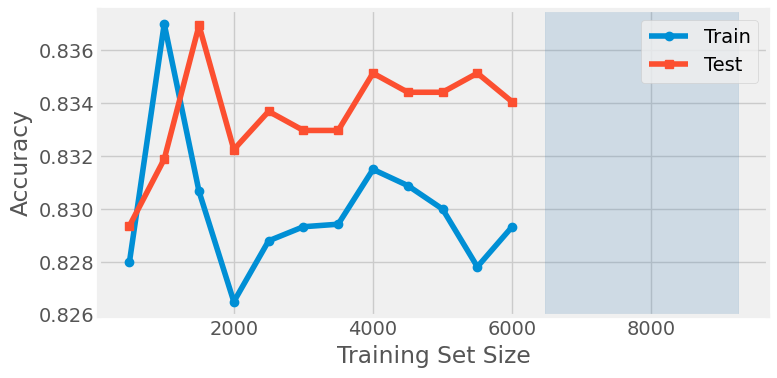

In [ ]:
with plt.style.context(('fivethirtyeight')):
    plt.figure(num=None, figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    # plt.xlim([530, X_train2.shape[0] + X_test2.shape[0]])
    plt.axvspan(X_train2.shape[0], 
                X_train2.shape[0] + X_test2.shape[0], 
                alpha=0.2, 
                color='steelblue')
    # plt.ylim([0.70, .75])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    # plt.savefig('figures/model-eval-mnist_0.svg')

# Model Pipeline

In [ ]:
X = leads_c.drop('Converted', axis=1)
y = leads_c['Converted']

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.33, 
                                                    random_state = 42)

In [ ]:
import sklearn.metrics as skm

@timer
# Classification - Model Pipeline
def modelPipeline(X_train, X_test, y_train, y_test):

    log_reg = LogisticRegression(**rs)
    nb = BernoulliNB()
    knn = KNeighborsClassifier()
    svm = SVC(**rs)
    mlp = MLPClassifier(max_iter=500, **rs)
    dt = DecisionTreeClassifier(**rs)
    et = ExtraTreesClassifier(**rs)
    rf = RandomForestClassifier(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    scorer = make_scorer(f1_score)

    clfs = [
            ('Logistic Regression', log_reg), 
            ('Naive Bayes', nb),
            ('K-Nearest Neighbors', knn), 
            ('SVM', svm), 
            ('MLP', mlp), 
            ('Decision Tree', dt), 
            ('Extra Trees', et), 
            ('Random Forest', rf), 
            ('XGBoost', xgb)
            ]


    pipelines = []

    scores_df = pd.DataFrame(columns=['Model', 'F1_Score', 'Precision', 'Recall', 'Accuracy', 'ROC_AUC'])


    for clf_name, clf in clfs:

        pipeline = Pipeline(steps=[
                                   ('scaler', StandardScaler()),
                                   ('classifier', clf)
                                   ]
                            )
        pipeline.fit(X_train, y_train)


        y_pred = pipeline.predict(X_test)
        # F1-Score
        fscore = skm.f1_score(y_test, y_pred)
        # Precision
        pres = skm.precision_score(y_test, y_pred)
        # Recall
        rcall = skm.recall_score(y_test, y_pred)
        # Accuracy
        accu = skm.accuracy_score(y_test, y_pred)
        # ROC_AUC
        roc_auc = skm.roc_auc_score(y_test, y_pred)


        pipelines.append(pipeline)

        scores_df = scores_df.append({
                                      'Model' : clf_name, 
                                      'F1_Score' : fscore,
                                      'Precision' : pres,
                                      'Recall' : rcall,
                                      'Accuracy' : accu,
                                      'ROC_AUC' : roc_auc
                                      
                                      }, 
                                     ignore_index=True)
        
    return pipelines, scores_df

In [ ]:
pipelines1, scores_df1 = modelPipeline(X_train, X_test, y_train, y_test)

Finished 'modelPipeline' in 33.534 secs


In [ ]:
scores_df1.sort_values(by="F1_Score", ascending=False).round(3)

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC
8,XGBoost,0.927,0.944,0.944,0.944,0.938
7,Random Forest,0.914,0.934,0.934,0.934,0.927
6,Extra Trees,0.903,0.925,0.925,0.925,0.918
5,Decision Tree,0.875,0.901,0.901,0.901,0.897
4,MLP,0.858,0.890,0.890,0.890,0.883
3,SVM,0.818,0.862,0.862,0.862,0.849
2,K-Nearest Neighbors,0.817,0.858,0.858,0.858,0.849
0,Logistic Regression,0.784,0.836,0.836,0.836,0.822
1,Naive Bayes,0.701,0.744,0.744,0.744,0.747


In [ ]:
scores_df1.sort_values(by="F1_Score", ascending=False)

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC
8,XGBoost,0.927389,0.943934,0.943934,0.943934,0.937739
7,Random Forest,0.914043,0.933770,0.933770,0.933770,0.926734
6,Extra Trees,0.902925,0.924918,0.924918,0.924918,0.918120
5,Decision Tree,0.875000,0.900984,0.900984,0.900984,0.897206
4,MLP,0.858463,0.889508,0.889508,0.889508,0.882646
3,SVM,0.818182,0.862295,0.862295,0.862295,0.848993
2,K-Nearest Neighbors,0.817259,0.858361,0.858361,0.858361,0.848800
0,Logistic Regression,0.783514,0.836393,0.836393,0.836393,0.821511
1,Naive Bayes,0.701338,0.743934,0.743934,0.743934,0.747248


In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb

import time

import warnings
warnings.filterwarnings('ignore')



def log_transform(x):
    return np.log1p(x)

def inverse_log_transform(x):
    return np.expm1(x)


def get_classifiers():

    """
    Provide lists of classifiers and their names.
    """
    n_jobs       = -1
    random_state =  1

    classifiers = [
                   DummyClassifier(), 
                   LogisticRegression(n_jobs=n_jobs), 
                   RidgeClassifier(random_state=random_state), 
                   MultinomialNB(),
                   KNeighborsClassifier(n_jobs=n_jobs),
                   SGDClassifier(random_state=random_state),
                   SVC(random_state=random_state),
                   DecisionTreeClassifier(random_state=random_state),
                   RandomForestClassifier(n_jobs=n_jobs, random_state=random_state),
                   GradientBoostingClassifier(random_state=random_state),
                   lgb.LGBMClassifier(n_jobs=n_jobs, random_state=random_state),
                   xgb.XGBClassifier(n_jobs=n_jobs, random_state=random_state),
    ]

    clf_names = [
                "DummyClassifier        ",
                "LogisticRegression     ", 
                "RidgeClassifier        ",
                "MultinomialNB          ",
                "KNeighborsClassifier   ",
                "SGDClassifier          ",
                "SVC                    ",
                "DecisionTreeClassifier ",
                "RandomForestClassifier ", 
                "GBMClassifier          ", 
                "LGBMClassifier         ", 
                "XGBoostClassifier      ",
    ]

    return clf_names, classifiers



def prepare_data(df, target_name):

    """
    Separate descriptive variables and target variable.
    Separate numerical and categorical columns.
    """

    if target_name is not None:
        X = df.drop(target_name, axis=1)
        y = df[target_name]
    else:
        X = df
        y = None

    # get list of numerical & categorical columns in order to process these separately in the pipeline 
    num_cols = X.select_dtypes("number").columns
    cat_cols = X.select_dtypes("object").columns
    
    return X, y, num_cols, cat_cols


def get_pipeline(classifier, num_cols, cat_cols, impute_strategy, log_x):

    """
    Create Pipeline with a separate pipe for categorical and numerical data.
    Automatically impute missing values, scale and then one hot encode.
    """

    # the numeric transformer gets the numerical data acording to num_cols
    # first step: the imputer imputes all missing values to the provided strategy argument
    # second step: all numerical data gets stanadard scaled 
    if log_x == False:
        numeric_transformer = Pipeline(steps=[
            ('imputer', make_pipeline(SimpleImputer(strategy=impute_strategy))),
            ('scaler', StandardScaler()),
            ('scaler_min_max', MinMaxScaler()),
            ])
    # if log_x is "True" than log transform feature values
    else:
        numeric_transformer = Pipeline(steps=[
            ('imputer', make_pipeline(SimpleImputer(strategy=impute_strategy))),
            ('log_transform', FunctionTransformer(np.log1p)),
            ('scaler_std', StandardScaler()),
            ('scaler_min_max', MinMaxScaler()),
            ])
    
    # the categorical transformer gets all categorical data according to cat_cols
    # first step: imputing missing values
    # second step: one hot encoding all categoricals
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    # the column transformer creates one Pipeline for categorical and numerical data each
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)])
    
    # return the whole pipeline for the classifier provided in the function call
    return Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])



def score_models(df, target_name, sample_size=None, 
    impute_strategy="mean", scoring_metric="accuracy", log_x=False, verbose=True):

    """
    This function yields scores for a large variety of common classifiers on provided training data. 

    Function separates numerical and categorical data based on dtypes of the dataframe columns. Missing values are imputed. Categorical data is one hot encoded, numerical data standard scaled. All classifiers are used with default settings and crossvalidated.
    
    The function returns a dataframe with scores of all classifiers as well as the mean of all results in the last row of the dataframe.

    Parameters
    ----------
    df : Pandas dataframe 
        Pandas dataframe with your training data
    target_name : str
        Column name of target variable
    sample_size : int, default "None" (score on all available samples)
        Number of samples for scoring the model
    impute_strategy : str, default "mean" 
        Strategy for SimpleImputer, can be "mean" (default), "median", "most_frequent" or "constant"
    scoring_metric : str, default "accuracy"
        scoring metric for classifier: "accuracy" (default), any scikit-learn metric for classification
        e.g. "roc_auc", "precision", "recall", "f1" see sklearn.metrics.SCORERS.keys()
    log_x : bool, default "False" 
        Log transform features variable(s)
    verbose : bool, default "True" 
        Print results during crossvalidation
    
    Returns
    -------
    DataFrame
        1st column : Name of classifier
        2nd column : scoring result

    Example
    -------
        X, y = sklearn.datasets.make_classification()
        X, X_test, y, _ = train_test_split(X, y)

        df = pd.DataFrame(X)
        df["target_variable"] = y
        df_test = pd.DataFrame(X_test)

        scores = score_models(df, "target_variable")
        display(scores)
        
        # further use: train and predict
        pipelines = train_models(df, "target_variable")
        predictions = predict_from_models(df_test, pipelines)
        predictions.head()

    """

    
    if sample_size is not None:
        df = df.sample(sample_size)
  
    # retrieve X, y and separated columns names for numerical and categorical data
    X, y, num_cols, cat_cols = prepare_data(df, target_name)

    scores = []

    clf_names, classifiers = get_classifiers()
    if verbose == True:
        print(f"Classifier             Metric ({scoring_metric})")
        print("-"*30)
    for clf_name, classifier in zip(clf_names, classifiers):
        start_time = time.time()
        
        # create a pipeline for each classifier
        clf = get_pipeline(classifier, num_cols, cat_cols, impute_strategy, log_x)
                
        # crossvalidate classifiers on training data
        cv_score = cross_val_score(clf, X, y, cv=3, scoring=scoring_metric)
        
        if verbose == True:
            print(f"{clf_name} {cv_score.mean(): .4f}  |  {(time.time() - start_time):.2f} secs")
        
        scores.append([clf_name.strip(), cv_score.mean()])

    scores = pd.DataFrame(scores, columns=["Classifier", scoring_metric]).sort_values(scoring_metric, ascending=False)
    
    # just for good measure: add the mean of all scores to dataframe
    scores.loc[len(scores) + 1, :] = ["mean_all", scores[scoring_metric].mean()]

    return scores.reset_index(drop=True)
    


def train_models(df, target_name, 
    impute_strategy="mean", log_x=False, verbose=True): 

    """
    This function trains a large variety of common classifiers on provided training data. 

    It separates numerical and categorical data based on dtypes of the dataframe columns. Missing values are imputed. Categorical data is one hot encoded, numerical data standard scaled. Each classifier is then trained with default settings.
    
    The function returns a list of fitted scikit-learn Pipelines.

    Parameters
    ----------
    df : Pandas dataframe 
        Pandas dataframe with your training data
    target_name : str
        Column name of target variable
    sample_size : int, default "None" (score on all available samples)
        Number of samples for scoring the model
    impute_strategy : str, default "mean" 
        Strategy for SimpleImputer, can be "mean" (default), "median", "most_frequent" or "constant"
    log_x : bool, default "False" 
        Log transform features variable(s)
    verbose : bool, default "True" 
        Print results during crossvalidation
    
    Returns
    -------
    List of fitted scikit-learn Pipelines

    Example:
        X, y = sklearn.datasets.make_classification()
        X, X_test, y, _ = train_test_split(X, y)

        df = pd.DataFrame(X)
        df["target_variable"] = y
        df_test = pd.DataFrame(X_test)

        scores = score_models(df, "target_variable")
        display(scores)
        
        pipelines = train_models(df, "target_variable")

        # further use: predict from pipelines
        predictions = predict_from_models(df_test, pipelines)
        predictions.head()
    
    """

    X, y, num_cols, cat_cols = prepare_data(df, target_name)

    pipelines = []

    if verbose == True:
        print(f"Classifier            Training time")
        print("-"*40)
    
    clf_names, classifiers = get_classifiers()
    for clf_name, classifier in zip(clf_names, classifiers):
        start_time = time.time()
        clf = get_pipeline(classifier, num_cols, cat_cols, impute_strategy, log_x)
        clf.fit(X, y)
        if verbose == True:
            print(f"{clf_name}     {(time.time() - start_time):.2f} secs")
        pipelines.append(clf)
    
    return pipelines



def predict_from_models(df_test, pipelines):

    """
    This function makes predictions with a list of pipelines. Test data is treated in the same pipeline the classifiers were trained on. 
    
    The function returns a dataframe with all predictions ordered columnwise. Each column is named with the respective classifiers.

    Parameters
    ----------
    df_test : Pandas dataframe 
        Dataframe with test data
    pipelines: array
        List of scikit-learn pipelines (preferably from train_models())

    Returns
    -------
    Pandas dataframe with prediction from each classifier, ordered columnwise. 
    1 column = results of 1 classifier.
    
    Example:
        X, y = sklearn.datasets.classification()
        X, X_test, y, _ = train_test_split(X, y)

        df = pd.DataFrame(X)
        df["target_variable"] = y
        df_test = pd.DataFrame(X_test)

        scores = score_models(df, "target_variable")
        display(scores)
        
        pipelines = train_models(df, "target_variable")

        # further use: predict from pipelines
        predictions = predict_from_models(df_test, pipelines)
        predictions.head()
    
    """
    
    X_test, _ , _, _ = prepare_data(df_test, None)
    predictions = []
    
    for pipeline in pipelines:
        preds = pipeline.predict(X_test)
        predictions.append(preds)
        
    df_predictions = pd.DataFrame(predictions).T
    clf_names, _ = get_classifiers()
    df_predictions.columns = [clf_name.strip() for clf_name in clf_names]

    return df_predictions

In [ ]:
scores = score_models(leads_c, "Converted", verbose=True)

Classifier             Metric (accuracy)
------------------------------
DummyClassifier          0.5248  |  0.07 secs
LogisticRegression       0.8318  |  1.51 secs
RidgeClassifier          0.8326  |  0.12 secs
MultinomialNB            0.7883  |  0.10 secs
KNeighborsClassifier     0.8295  |  1.29 secs
SGDClassifier            0.8298  |  0.18 secs
SVC                      0.8430  |  4.36 secs
DecisionTreeClassifier   0.8968  |  0.14 secs
RandomForestClassifier   0.9148  |  2.23 secs
GBMClassifier            0.9341  |  2.74 secs
LGBMClassifier           0.9366  |  0.72 secs
XGBoostClassifier        0.9323  |  1.31 secs


In [ ]:
# pipelines = train_models(X_train, "Converted", verbose=False)


# predictions = predict_from_models(X_test, pipelines)
# predictions.head()